### Analysis of the LFQ single-cell dataset generated in Bremen on OLEP7

In [2]:
#Importing packages 
import pandas as pd 
import numpy as np
import os 
import glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from scipy import stats
from scipy.stats import mstats
sns.set_style("ticks")

/Users/valdemaras/Programs/miniconda/miniconda3/envs/singleCell/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Reading data 
sc = pd.read_csv('data/MESC/mesc_proteinQuant_direct.tsv', delimiter= "\t", decimal = ",") # does not work with the comma decimanl...
#Replacing filtered with NA 
acc_genes = sc.iloc[:,0:2]
#new_cols = sc.columns.str.extract(r'scMESC_(.*)\.raw').values.reshape(-1)
#new_cols[0:2] = ['PG.ProteinGroups', 'PG.Genes']
#sc.columns = new_cols
sc = sc.loc[:,sc.columns.str.contains(r'GFP') == False]
sample_facs = pd.read_csv('data/MESC/sample_facs.csv', sep = "\t", index_col=0)
sample_facs

keratin = pd.read_csv('data/MESC/mus_musculus_keratin.tsv', sep = "\t")

sc = sc.loc[sc['PG.ProteinGroups'].isin(keratin.Entry.values) == False,:]

In [4]:
class proteinQuant:

    def __init__(self, ms_data, facs_data):
        #Save the raw input data here 
        self.ms_data = ms_data
        self.facs_data = facs_data


        #Run these function as soon as the object is created 
        self.extract_quant()
        self.cellSummary()
        self.QC_filter()
        #Generate a quant table from the MS data 
    def extract_quant(self):
        quant = self.ms_data.drop(columns = ['PG.Genes']) # drop the gene column
        quant = quant.set_index('PG.ProteinGroups')
        quant.columns = quant.columns.str.extract(r'] (.*)\.raw')[0].values
        self.quant = quant.replace('Filtered', np.nan).apply(pd.to_numeric)
    
    def cellSummary(self):
        detected_proteins = (self.quant > 0).sum(axis=0).values
        Intensity = self.quant.apply(lambda x: np.log2(np.nanmedian(x)), axis = 0).values
        FileName = self.quant.columns
        CellID = ['cell_' + str(i) for i in list(range(self.quant.shape[1]))] # generate an arbitrary cell ID 
        cell_type = self.quant.columns.str.extract(r'scMESC_(.*)_').values.reshape(-1)
        #Mark Cell bellow QC
        self.summary = pd.DataFrame(
                      {'File_Name': FileName,
                       'CellID': CellID,              
                      'Detected_Proteins' : detected_proteins,
                      'Intensity': Intensity,
                      'CellType': cell_type
                    })
        self.summary['QC_Pass'] = np.where((self.summary.Intensity < 10) & (self.summary.Detected_Proteins > 400), True, False)

    # Add FACS data, this is kept as a separate function incase the FACS data is not presenet for now
    def addFACS(self):
        self.summary = pd.merge(self.summary, self.facs_data, how='left', left_on = 'File_Name', right_on = 'File Name').drop(columns=['File Name'])

    def QC_filter(self):
        self.quant_filtered = self.quant.loc[:,self.summary.QC_Pass.values]
        

    def impute_values(self):
      #Missing value imputation 
      totalCells = self.quant_filtered.shape[1] # get total number of cells analyzed
      missingInRow = pd.DataFrame(totalCells - self.quant_filtered.isnull().sum(axis = 1))
      
      missingInRow['to_impute'] = (missingInRow[0]/totalCells) > 0.3
      quant_imputed = self.quant_filtered.loc[missingInRow['to_impute'],:]
      #Imputing missing values with knn 
      from sklearn.impute import KNNImputer
      imputer = KNNImputer(n_neighbors=5, weights="uniform")
      self.quant_imputed = pd.DataFrame(np.exp(imputer.fit_transform(np.log(quant_imputed))))
      self.quant_imputed.columns = quant_imputed.columns
      self.quant_imputed.index = quant_imputed.index
    
sc_quant = proteinQuant(sc, sample_facs)
sc_quant.impute_values()
sc_quant.addFACS()

/Users/valdemaras/Programs/miniconda/miniconda3/envs/singleCell/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [5]:
sc_quant.summary

File_Name    CellID  \
0    20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...    cell_0   
1    20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...    cell_1   
2    20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...    cell_2   
3    20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...    cell_3   
4    20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...    cell_4   
..                                                 ...       ...   
604  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...  cell_604   
605  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...  cell_605   
606  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...  cell_606   
607  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...  cell_607   
608  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...  cell_608   

     Detected_Proteins  Intensity CellType  QC_Pass Position        TIME  \
0                  444   8.595065      m15     True       A1    9.578034   
1                 1140   7.493173      m15     True      A10  175.411600   
2                  726   8.367414      m15     True      E12  203.361600   
3                  950   8.050534      m15     True      E13  212.681500   
4                  994   8.056626      m15     True      E14  236.449100   
..                 ...        ...      ...      ...      ...         ...   
604                709   8.433825      m2i     True       E7  105.881500   
605                728   8.477236      m2i     True       E8  129.721100   
606                904   8.038930      m2i     True       E9  138.741400   
607                822   8.302719      m2i     True      E10  162.492100   
608                957   8.144512      m2i     True      E11  171.745600   

        FSC-A     FSC-H  FSC-W     BSC-A     BSC-H  BSC-W  DAPI-A-Compensated  \
0    571065.4  368505.8    403  279154.9  194003.0    403           1196.1860   
1    527701.3  369080.3    417  363468.1  238843.4    417           2583.5470   
2    425250.5  299901.3    395  361996.5  261726.1    395            825.6260   
3    847968.1  569449.4    452  411174.5  272608.0    452           2182.7600   
4    661363.8  402937.9    425  330298.6  229807.2    425           1493.7640   
..        ...       ...    ...       ...       ...    ...                 ...   
604  350880.7  205727.2    344  467516.9  312540.5    344            892.0246   
605  344023.9  206935.7    334  547166.3  342671.8    334            726.6935   
606  689102.9  506783.2    422  314805.0  215704.2    422           1356.6640   
607  496285.9  294105.3    416  485967.8  324436.0    416           1053.6380   
608  671014.0  505257.8    449  514492.4  303212.0    449            770.6191   

    Plate  
0     m15  
1     m15  
2     m15  
3     m15  
4     m15  
..    ...  
604   m2i  
605   m2i  
606   m2i  
607   m2i  
608   m2i  

[609 rows x 16 columns]

<AxesSubplot:xlabel='DAPI-A-Compensated', ylabel='FSC-A'>

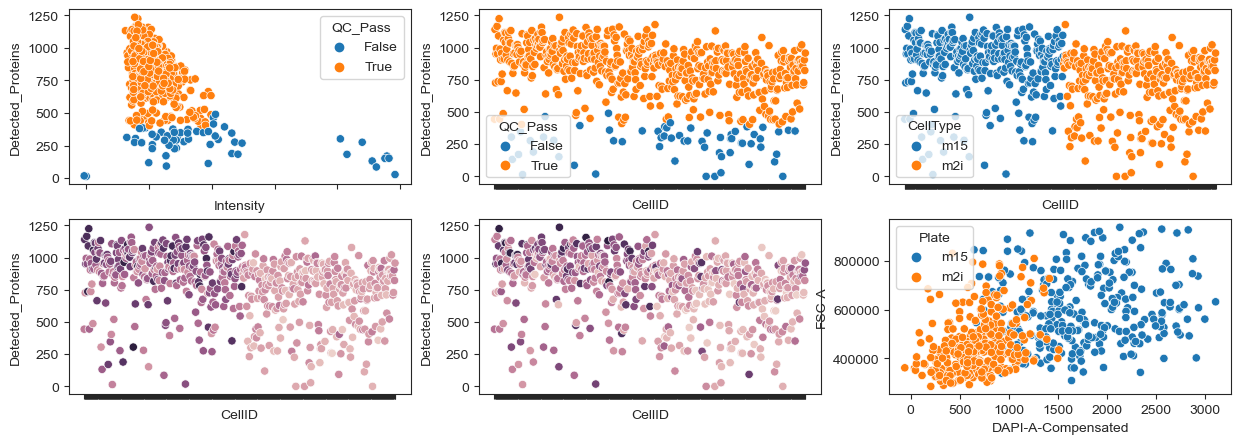

In [6]:
fig, axes = plt.subplots(2,3,figsize=(15,5), facecolor = "w")

sns.scatterplot(data = sc_quant.summary, y = 'Detected_Proteins', x = 'Intensity', hue = 'QC_Pass',ax =axes[0,0]).set(xticklabels=[])
sns.scatterplot(data = sc_quant.summary, x = 'CellID', y = 'Detected_Proteins', hue = 'QC_Pass',ax =axes[0,1]).set(xticklabels=[])
sns.scatterplot(data = sc_quant.summary, y = 'Detected_Proteins', x = 'CellID', hue = 'CellType',ax =axes[0,2]).set(xticklabels=[])
sns.scatterplot(data = sc_quant.summary, y = 'Detected_Proteins', x = 'CellID', hue = 'DAPI-A-Compensated',ax =axes[1,0], legend = False).set(xticklabels=[])
sns.scatterplot(data = sc_quant.summary, y = 'Detected_Proteins', x = 'CellID', hue = 'FSC-A',ax =axes[1,1], legend = False).set(xticklabels=[])
sns.scatterplot(data = sc_quant.summary, x = 'DAPI-A-Compensated', y = 'FSC-A', hue = 'Plate',ax =axes[1,2])

/Users/valdemaras/Programs/miniconda/miniconda3/envs/singleCell/lib/python3.10/site-packages/seaborn/distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


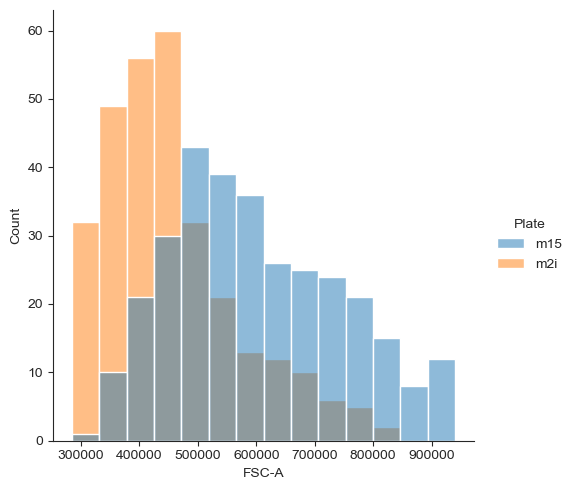

In [7]:
sns.displot(data = sc_quant.summary, x = 'FSC-A', hue = 'Plate', ax = axes[0])

In [8]:
sc_quant.summary.groupby(['CellType'])['Detected_Proteins'].apply(lambda x: np.median(x))

CellType
m15    926.0
m2i    783.0
Name: Detected_Proteins, dtype: float64

In [9]:
sc.iloc[np.where(sc['PG.Genes'].str.contains('Dnmt') == True)[0],0:2]

PG.ProteinGroups PG.Genes
120   O88508;O88508-2   Dnmt3a
220            P13864    Dnmt1
1437           Q9CWR8   Dnmt3l

### Check if there is any correlation with proteins that are missing 

In [10]:
quant = sc_quant.quant_filtered.copy(deep=False)

quant.columns = quant.columns.str.extract(r'scMESC_(.*)_').values.reshape(-1)

quant = quant.T.reset_index()
na_count = quant.groupby('index').apply(lambda x: np.sum(np.isnan(x))).T
na_count['m15_frac'] = na_count.m15.values/na_count.shape[0]
na_count['m2i_frac'] = na_count.m2i.values/na_count.shape[0]
na_count['total_frac'] = (na_count.m2i.values + na_count.m15.values)/na_count.shape[0]
na_count['ratio'] = na_count.m15_frac.values/na_count.m2i_frac.values
na_count['ratio_log'] = np.log2(na_count.ratio)
na_count = na_count.reset_index()

quant_avg = pd.melt(sc_quant.quant_filtered.copy(deep=False), ignore_index=False)
quant_avg['CellType'] = quant_avg.variable.str.extract(r'scMESC_(.*)_').values.reshape(-1)
quant_avg = quant_avg.groupby(['PG.ProteinGroups','CellType']).value.apply(lambda x: np.nanmean(x))
quant_avg = pd.DataFrame(quant_avg).reset_index().pivot(index='PG.ProteinGroups', columns='CellType', values='value')
quant_avg.columns = ['m15_avg', 'm2i_avg']
quant_avg['m15_avg'] = np.log2(quant_avg['m15_avg'])
quant_avg['m2i_avg'] = np.log2(quant_avg['m2i_avg'])
na_count = na_count.merge(quant_avg, on = 'PG.ProteinGroups')
#sns.scatterplot(data=na_count, x = 'm2i_frac', y = 'm15_frac')

/var/folders/fk/ycgfqq1520l3t9l7gs4wsjyr0000gp/T/ipykernel_5139/1668977068.py:10: RuntimeWarning: divide by zero encountered in divide
  na_count['ratio'] = na_count.m15_frac.values/na_count.m2i_frac.values
/var/folders/fk/ycgfqq1520l3t9l7gs4wsjyr0000gp/T/ipykernel_5139/1668977068.py:10: RuntimeWarning: invalid value encountered in divide
  na_count['ratio'] = na_count.m15_frac.values/na_count.m2i_frac.values
/Users/valdemaras/Programs/miniconda/miniconda3/envs/singleCell/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/fk/ycgfqq1520l3t9l7gs4wsjyr0000gp/T/ipykernel_5139/1668977068.py:16: RuntimeWarning: Mean of empty slice
  quant_avg = quant_avg.groupby(['PG.ProteinGroups','CellType']).value.apply(lambda x: np.nanmean(x))


<AxesSubplot:xlabel='m15_avg', ylabel='ratio'>

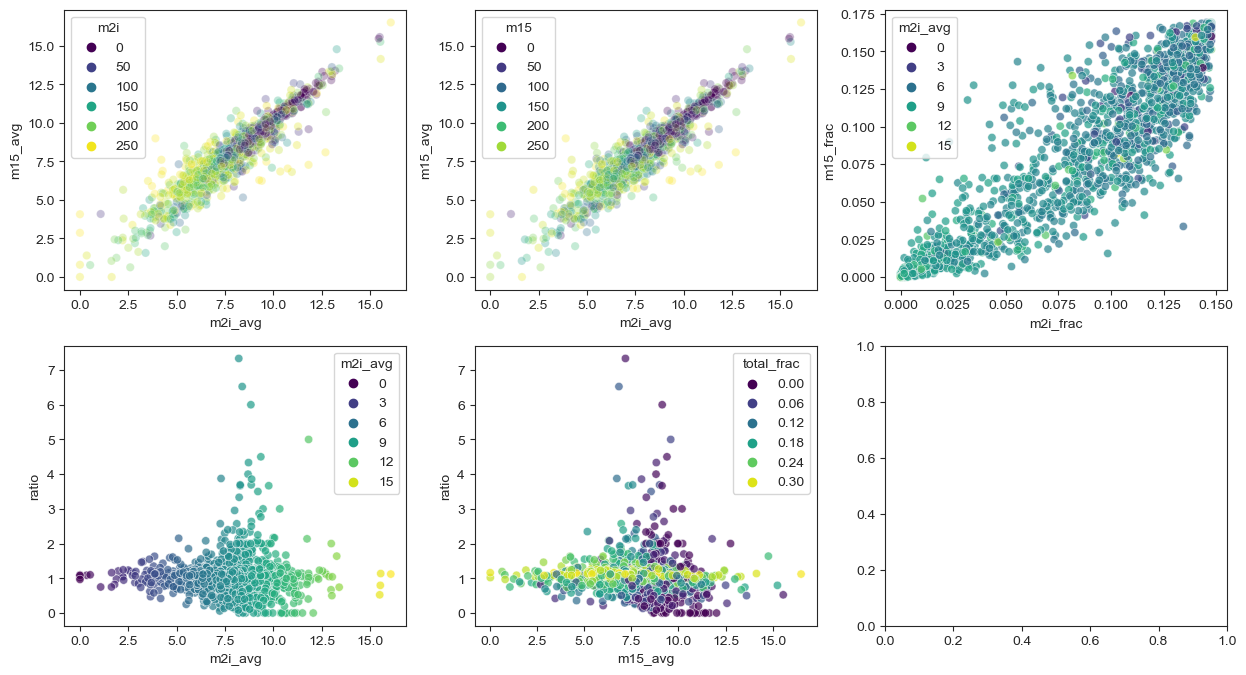

In [11]:
fig, axes  = plt.subplots(2,3,figsize=(15,8), facecolor = "w")
sns.scatterplot(data = na_count, x = 'm2i_avg', y ='m15_avg', hue = 'm2i', palette = 'viridis', ax = axes[0,0], alpha = 0.3)
sns.scatterplot(data = na_count, x = 'm2i_avg', y ='m15_avg', hue = 'm15', palette = 'viridis', ax = axes[0,1], alpha = 0.3)
sns.scatterplot(data = na_count, x = 'm2i_frac', y ='m15_frac', hue = 'm2i_avg', palette = 'viridis', ax = axes[0,2], alpha = 0.7)
sns.scatterplot(data = na_count, x = 'm2i_avg', y ='ratio', hue = 'm2i_avg', palette = 'viridis', ax = axes[1,0], alpha = 0.7)
sns.scatterplot(data = na_count, x = 'm15_avg', y ='ratio', hue = 'total_frac', palette = 'viridis', ax = axes[1,1], alpha = 0.7)

In [12]:
na_count.sort_values('ratio',ascending=False).iloc[:30,:]
sc_quant.quant_filtered.to_csv('output/mesc_QCpass_quant_direct.txt', sep = "\t")

In [13]:
na_count.sort_values('ratio',ascending=True).iloc[40:80,:]

PG.ProteinGroups  m15  m2i  m15_frac  m2i_frac  total_frac     ratio  \
828            Q61792   20  102  0.011587  0.059096    0.070684  0.196078   
1507           Q9D8E6    1    5  0.000579  0.002897    0.003476  0.200000   
749            Q587J6    2   10  0.001159  0.005794    0.006952  0.200000   
1663           Q9WTM5    1    5  0.000579  0.002897    0.003476  0.200000   
258            P19096    1    5  0.000579  0.002897    0.003476  0.200000   
144            P03930   11   54  0.006373  0.031286    0.037659  0.203704   
398            P48722   10   47  0.005794  0.027231    0.033024  0.212766   
221            P14602    6   28  0.003476  0.016222    0.019699  0.214286   
1703           Q9Z130    9   42  0.005214  0.024334    0.029548  0.214286   
443            P56135   11   50  0.006373  0.028969    0.035342  0.220000   
160            P08030   13   58  0.007532  0.033604    0.041136  0.224138   
59             O09061   15   66  0.008691  0.038239    0.046929  0.227273   
372            P45376   24   99  0.013905  0.057358    0.071263  0.242424   
1336           Q99MD9    1    4  0.000579  0.002317    0.002897  0.250000   
133            P00920   58  232  0.033604  0.134415    0.168019  0.250000   
831   Q61990;Q61990-3    4   16  0.002317  0.009270    0.011587  0.250000   
1523           Q9DB20    7   28  0.004056  0.016222    0.020278  0.250000   
1240           Q91VR2   10   38  0.005794  0.022016    0.027810  0.263158   
954            Q78IK2   32  121  0.018540  0.070104    0.088644  0.264463   
377            P46471    3   11  0.001738  0.006373    0.008111  0.272727   
793   Q61029;Q61029-3    8   29  0.004635  0.016802    0.021437  0.275862   
500            P62082   14   50  0.008111  0.028969    0.037080  0.280000   
455            P57780    8   28  0.004635  0.016222    0.020857  0.285714   
1410           Q9CWR8    8   28  0.004635  0.016222    0.020857  0.285714   
148            P05202    4   14  0.002317  0.008111    0.010429  0.285714   
850            Q62425   30  104  0.017381  0.060255    0.077636  0.288462   
1237           Q91VD9   38  130  0.022016  0.075319    0.097335  0.292308   
1489           Q9D6R2   15   51  0.008691  0.029548    0.038239  0.294118   
469            P59999   13   44  0.007532  0.025492    0.033024  0.295455   
282            P23492   23   77  0.013326  0.044612    0.057937  0.298701   
452            P56959    3   10  0.001738  0.005794    0.007532  0.300000   
66             O35286   10   33  0.005794  0.019119    0.024913  0.303030   
949            Q6ZWX6   10   33  0.005794  0.019119    0.024913  0.303030   
513            P62305   46  150  0.026651  0.086906    0.113557  0.306667   
1069           Q8BWY3    5   16  0.002897  0.009270    0.012167  0.312500   
166            P08249    5   16  0.002897  0.009270    0.012167  0.312500   
627   P97822;P97822-2   51  163  0.029548  0.094438    0.123986  0.312883   
33    E9Q5C9;E9Q5C9-2   31   99  0.017961  0.057358    0.075319  0.313131   
384            P47754   30   95  0.017381  0.055041    0.072422  0.315789   
1710           Q9Z1N5   31   96  0.017961  0.055620    0.073581  0.322917   

      ratio_log    m15_avg    m2i_avg  
828   -2.350497   8.111534   6.876717  
1507  -2.321928  11.060402  10.571928  
749   -2.321928   9.315051   8.562971  
1663  -2.321928   8.186876   7.716435  
258   -2.321928   8.283812   8.265793  
144   -2.295456   9.340737   8.569672  
398   -2.232661   6.000530   6.422483  
221   -2.222392   9.307715   9.026923  
1703  -2.222392   9.672786   9.246780  
443   -2.184425   8.872409   8.107227  
160   -2.157541   9.033012   8.580427  
59    -2.137504   9.290431   8.963206  
372   -2.044394   9.817950   9.016220  
1336  -2.000000   9.797945   9.890280  
133   -2.000000   7.679690   5.493839  
831   -2.000000   9.670322   8.920939  
1523  -2.000000   9.528845   9.132186  
1240  -1.925999   8.500077   8.425563  
954   -1.918863   7.682233   7.227160  
377   -1.874469   8.707029   8.619191  
793   -

In [14]:
na_count.loc[na_count.total_frac > 0.3,:].sort_values('ratio', ascending = True)

PG.ProteinGroups  m15  m2i  m15_frac  m2i_frac  total_frac     ratio  \
1598           Q9JJN6  267  254  0.154693  0.147161    0.301854  1.051181   
405            P50136  266  252  0.154114  0.146002    0.300116  1.055556   
73             O35639  271  255  0.157010  0.147740    0.304751  1.062745   
173            P09450  270  252  0.156431  0.146002    0.302433  1.071429   
134            P01027  269  251  0.155852  0.145423    0.301275  1.071713   
...               ...  ...  ...       ...       ...         ...       ...   
22             B1B1A0  286  239  0.165701  0.138470    0.304171  1.196653   
550            P63006  291  240  0.168598  0.139050    0.307648  1.212500   
1305           Q99JT9  285  235  0.165122  0.136153    0.301275  1.212766   
341            P35505  286  235  0.165701  0.136153    0.301854  1.217021   
634            P98063  288  235  0.166860  0.136153    0.303013  1.225532   

      ratio_log   m15_avg    m2i_avg  
1598   0.072011  7.275037   5.755440  
405    0.078003  6.338455   6.136670  
73     0.087796  6.886103   4.277814  
173    0.099536  7.606669   4.208469  
134    0.099919  7.612653   7.597243  
...         ...       ...        ...  
22     0.259005  4.467568   3.892012  
550    0.277985  6.816148  10.956154  
1305   0.278301  4.226350   3.669221  
341    0.283354  5.742924   7.389849  
634    0.293408  4.110145   3.458872  

[123 rows x 10 columns]

In [15]:
sc['PG.Genes'].values

sc.iloc[np.where(sc['PG.Genes'].str.contains('Mcm') == True)[0],0:2]

PG.ProteinGroups PG.Genes
303           P25206     Mcm3
411           P49717     Mcm4
412           P49718     Mcm5
617           P97310     Mcm2
618           P97311     Mcm6
846           Q61881     Mcm7

### Testing a few normalization strategies

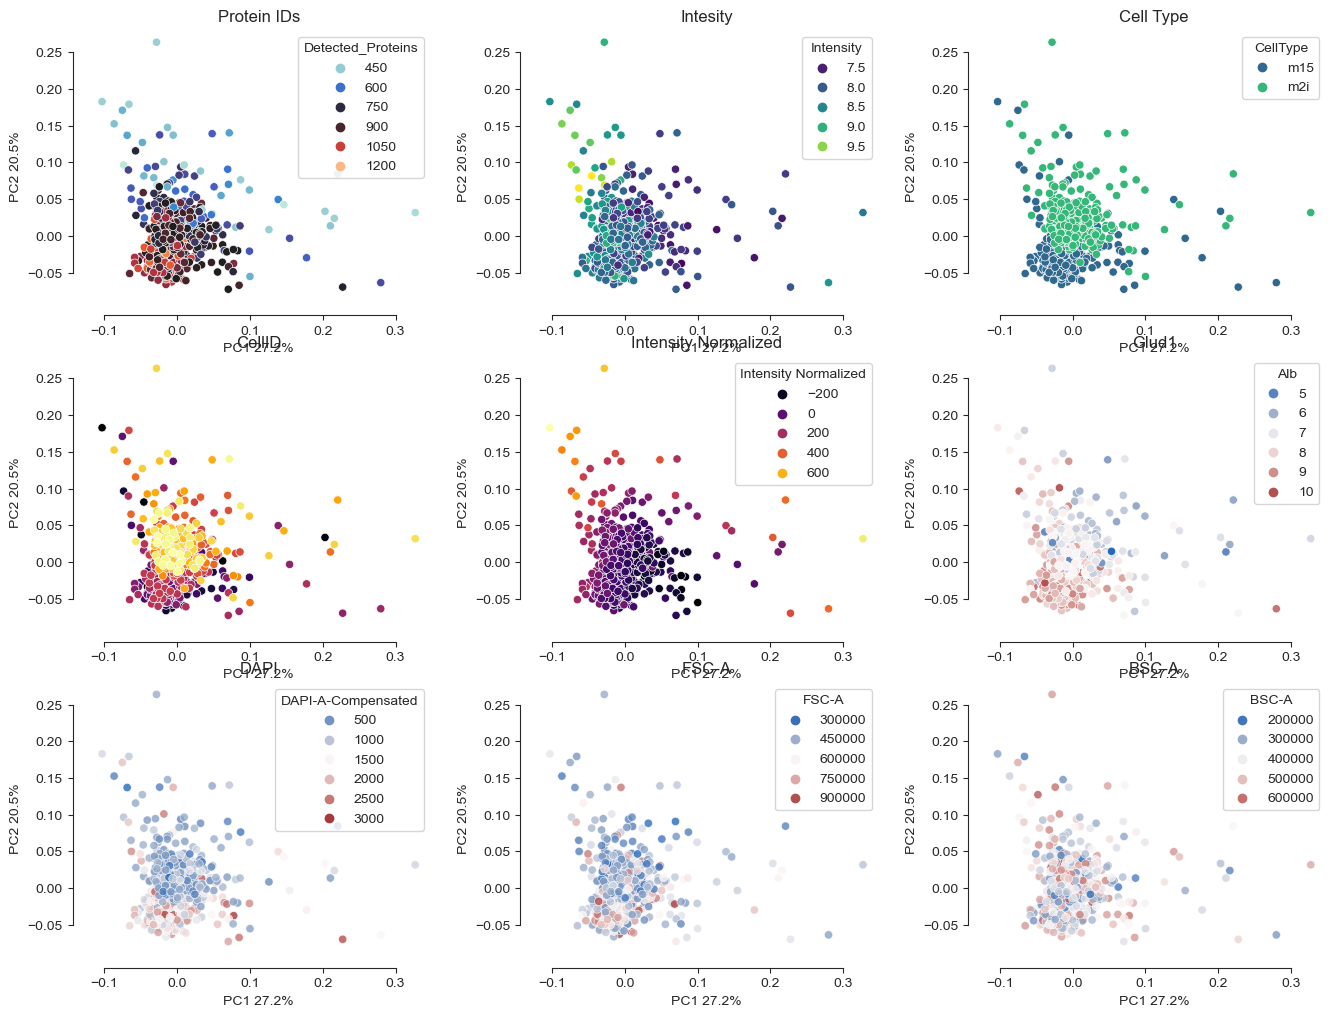

In [16]:
#### 2.1 PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
#pca.fit(np.log2(abundances_knn)) # just log transformed

### Double z-score
#data = sc_quant.quant_imputed.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 0)
#data = data.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 1)

#Robust z-score (median)
data = np.log2(sc_quant.quant_imputed).apply(lambda x: (x - np.nanmedian(x))/stats.median_abs_deviation(x), axis = 0)
#data = data.apply(lambda x: (x - np.nanmedian(x))/stats.median_abs_deviation(x), axis = 1)
data = np.power(data,2)
data = data.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 1)

#Trimmed mean z-score
#data = np.log2(sc_quant.quant_imputed).apply(lambda x: (x - stats.trim_mean(x[np.isnan(x) != True], 0.1))/stats.mstats.trimmed_std(x, 0.1), axis = 0)
#data = data.apply(lambda x: (x - stats.trim_mean(x[np.isnan(x) != True], 0.1))/stats.mstats.trimmed_std(x, 0.1), axis = 1)


#Robust z-score scaled to sample mean 
#sample_medians = sc_quant.quant_imputed.apply(lambda x: np.median(x), axis = 0) # calculate the median of sample medians
#dataset_median = np.median(sample_medians.values)8
#corrected_median = sample_medians.values/dataset_median
#
#corrected_data = sc_quant.quant_imputed/corrected_median
#
#data = corrected_data
#
#data = np.log2(data).apply(lambda x: (x - np.nanmedian(x))/stats.median_abs_deviation(x), axis = 0)
#data = data.apply(lambda x: (x - np.nanmedian(x))/stats.median_abs_deviation(x), axis = 1)
#data = np.power(data,2)
#data = data.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 1)


pca.fit(data) # scaled values 
pca_2 = pd.DataFrame(pca.components_)



#Formating PCA results for ploting 
pca_2 = pca_2.transpose()
pca_2.reset_index(level=0, inplace=True)
pcas =  ["PC1", "PC2", "PC3", "PC4", "PC5"]
test = [p + " " + str(np.round(v,1)) + "%" for p,v in zip(pcas, pca.explained_variance_)]
test.insert(0, 'Sample')
pca.explained_variance_

pca_2.columns = test

 
pca_2['File_Name'] = sc_quant.quant_imputed.columns
pca_2  = pca_2.merge(sc_quant.summary, how='left', on='File_Name')
pca_2['Intensity Normalized'] = data.apply(lambda x: np.sum(x), axis = 0).values
pca_2['Alb'] =  np.log2(sc_quant.quant_imputed.loc[ sc_quant.quant_imputed.index == 'P26443',:].values[0])

fig, axes = plt.subplots(3,3,figsize=(16,12), facecolor = "w")
#
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "Detected_Proteins", legend = True, palette= "icefire", ax = axes[0,0]).set_title('Protein IDs')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "Intensity", legend = True, palette= "viridis", ax = axes[0,1]).set_title('Intesity')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "CellType", legend = True, palette= "viridis", ax = axes[0,2]).set_title('Cell Type')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "CellID", legend = False, palette= "inferno", ax = axes[1,0]).set_title('CellID')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "Intensity Normalized", legend = True, palette= "inferno", ax = axes[1,1]).set_title('Intensity Normalized')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "Alb", legend = True, palette= "vlag", ax = axes[1,2]).set_title('Glud1')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "DAPI-A-Compensated", legend = True, palette= "vlag", ax = axes[2,0], alpha = 0.8).set_title('DAPI')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "FSC-A", legend = True, palette= "vlag", ax = axes[2,1], alpha = 0.8).set_title('FSC-A')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "BSC-A", legend = True, palette= "vlag", ax = axes[2,2], alpha = 0.8).set_title('BSC-A')
plt.subplots_adjust(wspace = 0.3)
sns.despine(offset=10, trim=True)


pca_2.to_csv('output/mesc_pca_unfiltered_direct.txt', sep = "\t")

### Remove the oulier cells in PC1 

In [17]:
## Extract cell numbers that PC1 value that makes them ouliers 

outlier_cells = pca_2.loc[((pca_2['PC1 27.2%'] > 0.09).values | (pca_2['PC2 20.5%'] > 0.11).values),:].File_Name.values

#outlier_cells = pca_2.loc[(pca_2['PC1 27.2%'] > 0.09).values ,:].File_Name.values
#outlier_cells = pca_2.loc[(pca_2['PC1 37.1%'] > 0.09).values ,:].File_Name.values
quant_filtered = sc_quant.quant_imputed.copy(deep=False)
quant_filtered = quant_filtered.loc[:, quant_filtered.columns.isin(outlier_cells) == False]
quant_filtered

20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate1_scMESC_m15_10  \
PG.ProteinGroups                                                                          
A2A432;A2A432-2                                                  223.067490               
A2AN08;A2AN08-3;A2AN08-5                                        2062.105957               
A2ARP1-5                                                         177.008636               
A2ASS6                                                           139.553284               
A2AVA0                                                            13.390863               
...                                                                     ...               
Q9Z2N8                                                            98.196556               
Q9Z2U0                                                           341.361145               
Q9Z2U1                                                           930.609680               
Q9Z2X1                                                          1335.874146               
Q9Z315                                                            85.275337               

                          20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate1_scMESC_m15_100  \
PG.ProteinGroups                                                                           
A2A432;A2A432-2                                                  184.291228                
A2AN08;A2AN08-3;A2AN08-5                                        4262.684570                
A2ARP1-5                                                         290.096680                
A2ASS6                                                            72.577538                
A2AVA0                                                             2.592888                
...                                                                     ...                
Q9Z2N8                                                           158.283966                
Q9Z2U0                                                           334.163422                
Q9Z2U1                                                          1472.607544                
Q9Z2X1                                                          5388.937012                
Q9Z315                                                            63.638802                

                          20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate1_scMESC_m15_101  \
PG.ProteinGroups                                                                           
A2A432;A2A432-2                                                  258.377899                
A2AN08;A2AN08-3;A2AN08-5                                         127.537628                
A2ARP1-5                                                         125.946570                
A2ASS6                                                           233.446945                
A2AVA0                                                            11.506171                
...                                                                     ...                
Q9Z2N8                                                           180.447968                
Q9Z2U0                                                           369.024841                
Q9Z2U1                                                           809.772034                
Q9Z2X1                                                          1250.601563                
Q9Z315                                                           144.479366                

                          20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate1_scMESC_m15_102  \
PG.ProteinGroups                                                                           
A2A432;A2A432-2                                                  291.200409                
A2AN08;A2AN08-3;A2AN08-5                                        4065.281982                
A2ARP1-5                                                         142.516735     

#### Rerun the PCA

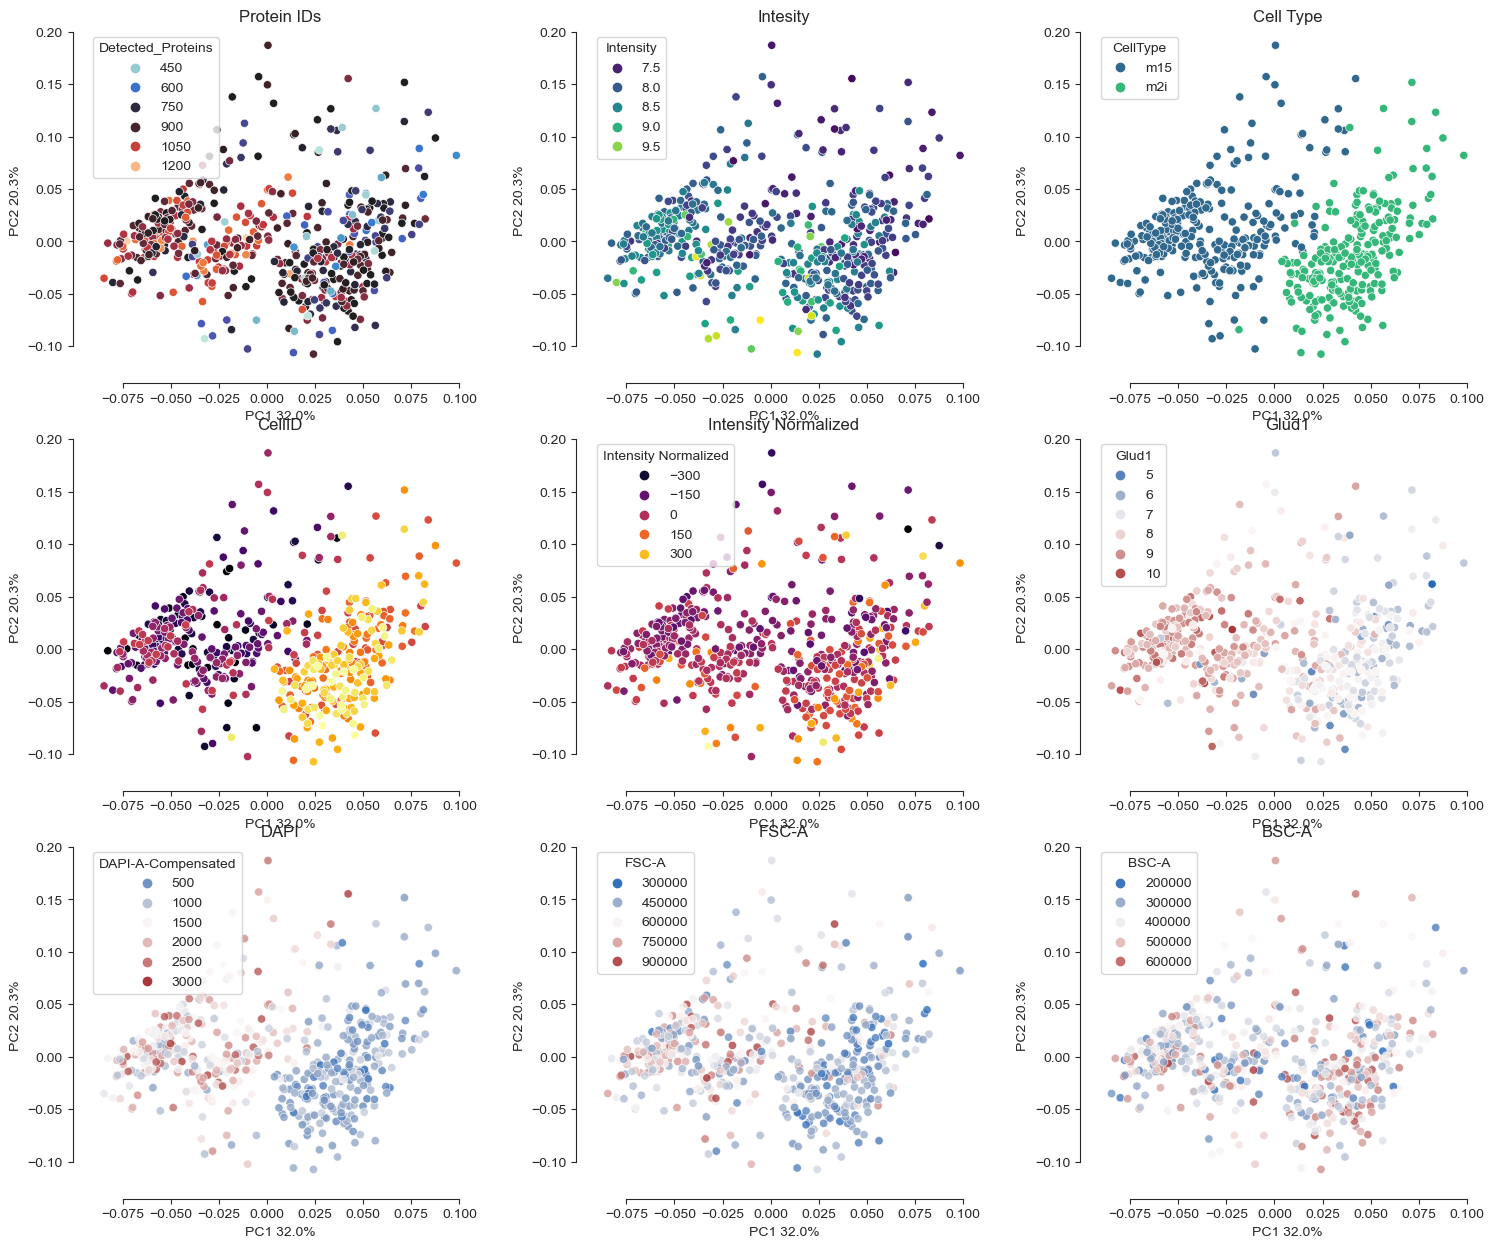

In [18]:
#### 2.1 PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
#pca.fit(np.log2(abundances_knn)) # just log transformed

### Double z-score
#data = sc_quant.quant_imputed.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 0)
#data = data.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 1)

#Robust z-score (median)
data = np.log2(quant_filtered).apply(lambda x: (x - np.nanmedian(x))/stats.median_abs_deviation(x), axis = 0)
#data = np.log2(quant_filtered).apply(lambda x: (x - np.nanmedian(x)), axis = 0)
#data = data.apply(lambda x: (x - np.nanmedian(x))/stats.median_abs_deviation(x), axis = 1)
#data = np.power(data,2)
#data = data.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 1)
data = data.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 1)


#Trimmed mean z-score
#data = np.log2(sc_quant.quant_imputed).apply(lambda x: (x - stats.trim_mean(x[np.isnan(x) != True], 0.1))/stats.mstats.trimmed_std(x, 0.1), axis = 0)
#data = data.apply(lambda x: (x - stats.trim_mean(x[np.isnan(x) != True], 0.1))/stats.mstats.trimmed_std(x, 0.1), axis = 1)


#Robust z-score scaled to sample mean 
#sample_medians = sc_quant.quant_imputed.apply(lambda x: np.median(x), axis = 0) # calculate the median of sample medians
#dataset_median = np.median(sample_medians.values)
#corrected_median = sample_medians.values/dataset_median
#
#corrected_data = sc_quant.quant_imputed/corrected_median
#
#data = corrected_data
#
#data = np.log2(data).apply(lambda x: (x - np.nanmedian(x))/stats.median_abs_deviation(x), axis = 0)
#data = data.apply(lambda x: (x - np.nanmedian(x))/stats.median_abs_deviation(x), axis = 1)
#data = np.power(data,2)
#data = data.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 1)





pca.fit(data) # scaled values 
pca_2 = pd.DataFrame(pca.components_)

#Formating PCA results for ploting 
pca_2 = pca_2.transpose()
pca_2.reset_index(level=0, inplace=True)
pcas =  ["PC1", "PC2", "PC3", "PC4", "PC5"]
test = [p + " " + str(np.round(v,1)) + "%" for p,v in zip(pcas, pca.explained_variance_)]
test.insert(0, 'Sample')
pca.explained_variance_

pca_2.columns = test

 
pca_2['File_Name'] = quant_filtered.columns
pca_2  = pca_2.merge(sc_quant.summary, how='left', on='File_Name')
pca_2['Intensity Normalized'] = data.apply(lambda x: np.sum(x), axis = 0).values
pca_2['Glud1'] =  np.log2(quant_filtered.loc[quant_filtered.index == 'P26443',:].values[0])

fig, axes = plt.subplots(3,3,figsize=(18,15), facecolor = "w")
#
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "Detected_Proteins", legend = True, palette= "icefire", ax = axes[0,0]).set_title('Protein IDs')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "Intensity", legend = True, palette= "viridis", ax = axes[0,1]).set_title('Intesity')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "CellType", legend = True, palette= "viridis", ax = axes[0,2]).set_title('Cell Type')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "CellID", legend = False, palette= "inferno", ax = axes[1,0]).set_title('CellID')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "Intensity Normalized", legend = True, palette= "inferno", ax = axes[1,1]).set_title('Intensity Normalized')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "Glud1", legend = True, palette= "vlag", ax = axes[1,2]).set_title('Glud1')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "DAPI-A-Compensated", legend = True, palette= "vlag", ax = axes[2,0], alpha = 0.8).set_title('DAPI')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "FSC-A", legend = True, palette= "vlag", ax = axes[2,1], alpha = 0.8).set_title('FSC-A')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "BSC-A", legend = True, palette= "vlag", ax = axes[2,2], alpha = 0.8).set_title('BSC-A')
plt.subplots_adjust(wspace = 0.3)
sns.despine(offset=10, trim=True)

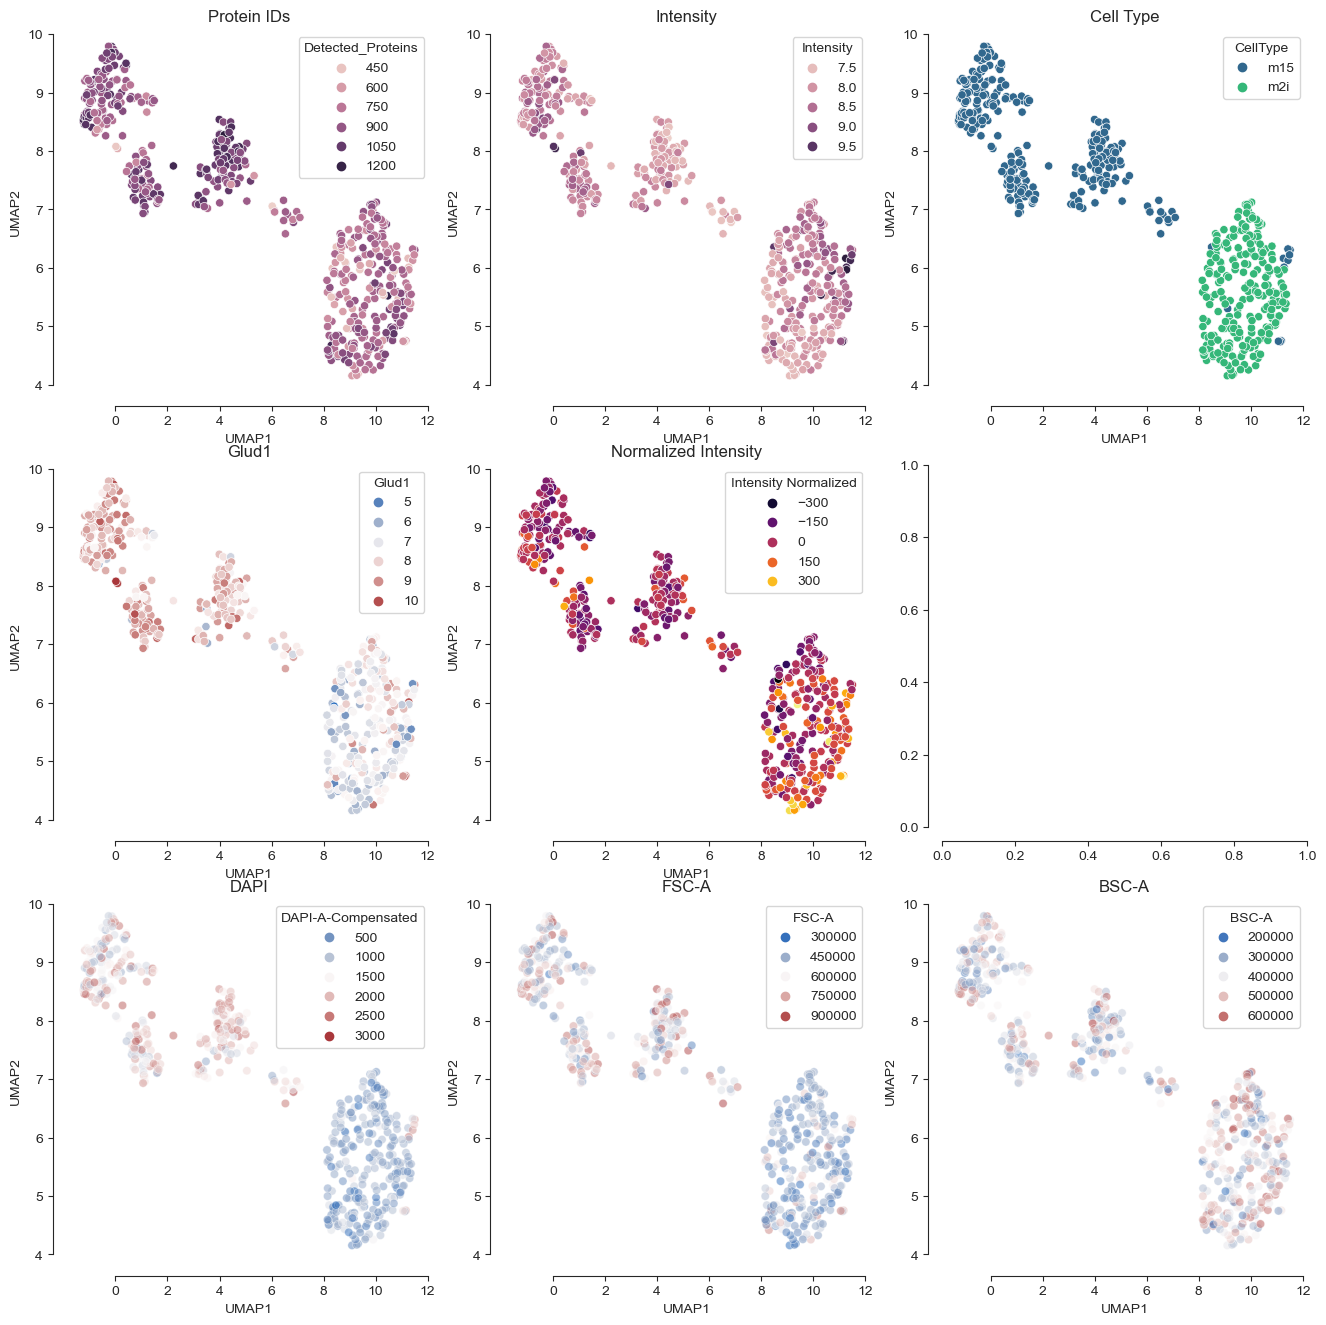

In [19]:
reducer = umap.UMAP(random_state = 42) 
#Scaling the imputed abundance values 
#data = sc_quant.quant_imputed.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 0)
#data = data.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 1)

embedding = reducer.fit_transform(data.T)
embedding.shape

#Reformat into a dataframe#
sc_emb = pd.DataFrame({'UMAP1': embedding[:,0], 'UMAP2': embedding[:,1], 'File_Name' : quant_filtered.columns})
sc_emb = sc_emb.merge(sc_quant.summary, on = 'File_Name')
sc_emb['Glud1'] = np.log2(quant_filtered.loc[quant_filtered.index == 'P26443',:].values[0])

#sc_emb['Glud1'] = np.log2(quant_filtered.loc[quant_filtered.index == 'P48722',:].values[0])
#sc_emb['Glud1'] = np.log2(quant_filtered.loc[quant_filtered.index == 'P35492',:].values[0])
sc_emb['Intensity Normalized'] = data.apply(lambda x: np.sum(x), axis = 0).values
#sc_emb['RRM2'] =  np.log2(sc_quant.quant_imputed.loc[sc_quant.quant_imputed.index == 'P31350;P31350-2',:]).apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 1).values[0]
#sc_emb['MKI67'] =  np.log2(sc_quant.quant_imputed.loc[sc_quant.quant_imputed.index == 'P46013',:]).apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 1).values[0]


fig, axes  = plt.subplots(3,3,figsize = (16,16))
sns.scatterplot(data = sc_emb, x = 'UMAP1', y = 'UMAP2', hue = 'Detected_Proteins', legend = True, ax = axes[0,0]).set_title('Protein IDs')
sns.scatterplot(data = sc_emb, x = 'UMAP1', y = 'UMAP2', hue = 'Intensity', legend = True, ax = axes[0,1]).set_title('Intensity')
sns.scatterplot(data = sc_emb, x = 'UMAP1', y = 'UMAP2', hue = 'CellType', legend = True, palette = "viridis", ax = axes[0,2]).set_title('Cell Type')
sns.scatterplot(data = sc_emb, x = 'UMAP1', y = 'UMAP2', hue = 'Glud1', legend = True, palette = "vlag", ax = axes[1,0]).set_title('Glud1')
sns.scatterplot(data = sc_emb, x = 'UMAP1', y = 'UMAP2', hue = 'Intensity Normalized', legend = True, palette = "inferno", ax = axes[1,1]).set_title('Normalized Intensity')
sns.scatterplot(data = sc_emb, x = 'UMAP1', y = 'UMAP2', hue = "DAPI-A-Compensated", legend = True, palette= "vlag", ax = axes[2,0], alpha = 0.5).set_title('DAPI')
sns.scatterplot(data = sc_emb, x = 'UMAP1', y = 'UMAP2', hue = "FSC-A", legend = True, palette= "vlag", ax = axes[2,1], alpha = 0.5).set_title('FSC-A')
sns.scatterplot(data = sc_emb, x = 'UMAP1', y = 'UMAP2', hue = "BSC-A", legend = True, palette= "vlag", ax = axes[2,2], alpha = 0.5).set_title('BSC-A')
sns.despine(offset=10, trim=True)

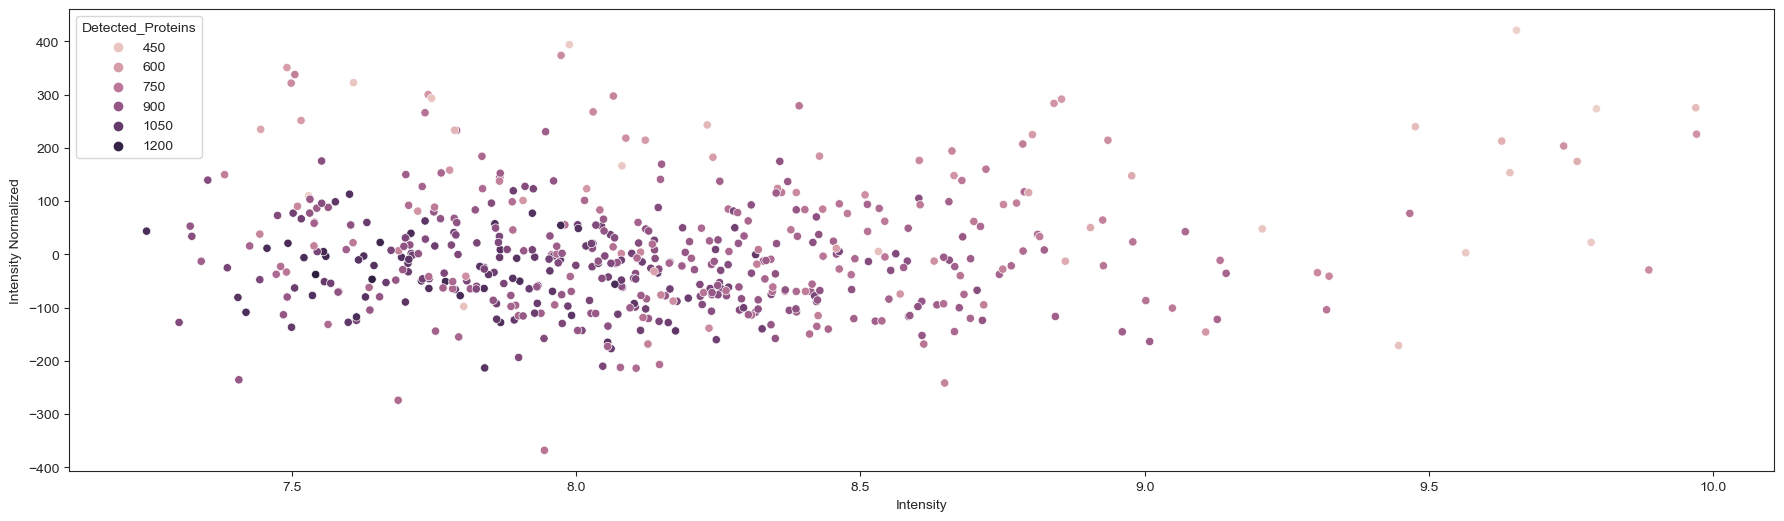

In [20]:
##Check the intensity correlation between raw and normalized 

plt.subplots(figsize=(22,6))
g = sns.scatterplot(data = pca_2, x = 'Intensity', y = 'Intensity Normalized', hue = 'Detected_Proteins')

### Check the data distribution (pre and post normalization)

[[Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, ''),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, ''),
  Text(45, 0, ''),
  Text(46, 0, ''),
  Text(47, 0, ''),
  Text(48, 0, ''),
  Text(49, 0, ''),
  Text(50, 0, ''),
  Text(51, 0, ''),
  Text(52, 0, ''),
  T

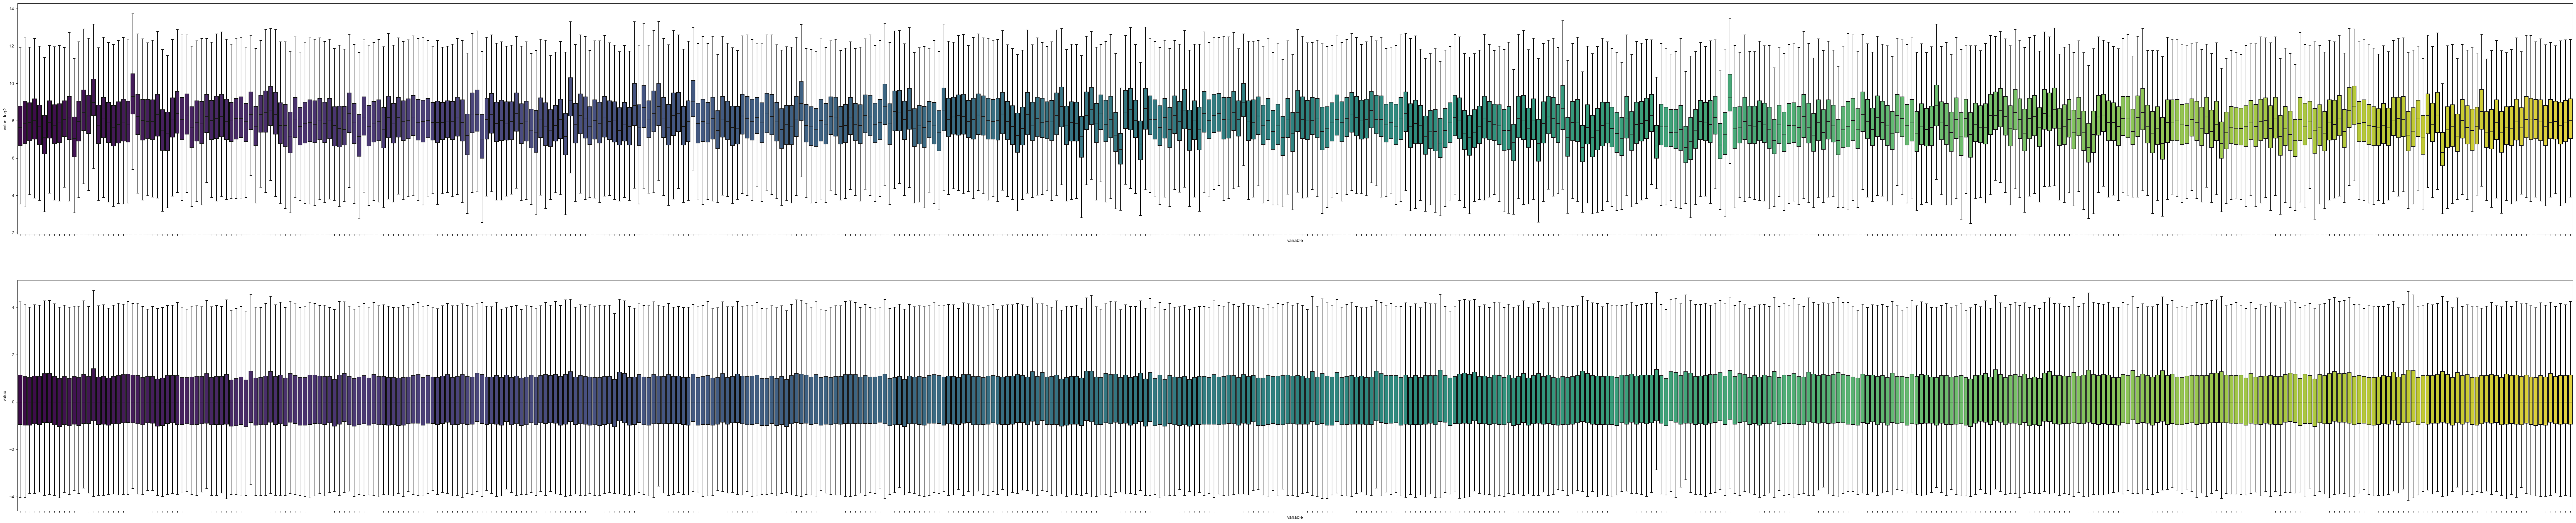

In [21]:
pre = pd.melt(quant_filtered)
pre['value_log2'] = np.log2(pre.value.values)
data = np.log2(quant_filtered).apply(lambda x: (x - np.nanmedian(x))/stats.median_abs_deviation(x), axis = 0)
post = pd.melt(data)
fig, axes = plt.subplots(2,1, figsize=(100,20))
sns.boxplot(data=pre, x = 'variable', y = 'value_log2', palette= "viridis",  showfliers = False, ax = axes[0]).set(xticklabels=[])
sns.boxplot(data=post, x = 'variable', y = 'value', palette= "viridis",  showfliers = False, ax = axes[1]).set(xticklabels=[])

In [22]:
#Recalculating moving averages without normalization
data = np.log2(quant_filtered).apply(lambda x: (x - stats.trim_mean(x[np.isnan(x) != True], 0.1))/stats.mstats.trimmed_std(x, 0.1), axis = 0)
#data = data.apply(lambda x: (x - stats.trim_mean(x[np.isnan(x) != True], 0.1))/stats.mstats.trimmed_std(x, 0.1), axis = 1)
data = data.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 1)
temp1 = data.T.reset_index()

temp2 = pca_2.merge(temp1, left_on='File_Name', right_on= 'index').sort_values(pca_2.columns[2])
#sns.clustermap(temp2.iloc[:,26:], figsize = (10,10), cmap = 'vlag', col_cluster=False, yticklabels = False)
diff = temp2.groupby(['CellType']).median().T.iloc[23:,]
diff['FC'] = diff.m15.values - diff.m2i.values
diff.sort_values('FC').iloc[10:,:]

CellType              m15       m2i        FC
P63158          -0.569621  0.625189 -1.194810
Q91V92          -0.413598  0.760633 -1.174231
Q61171          -0.560803  0.600975 -1.161778
P30681          -0.552622  0.591289 -1.143911
Q99K85          -0.469131  0.655417 -1.124548
...                   ...       ...       ...
Q3THS6           0.617303 -0.621501  1.238804
P57780           0.696646 -0.554441  1.251086
Q61316           0.667030 -0.600032  1.267062
Q8BP67           0.600150 -0.676314  1.276464
O55143;O55143-2  0.697023 -0.639240  1.336264

[1079 rows x 3 columns]

### Clustering based on the PCA and UMAP values for pseudo-bulk analysis 

##### PCA

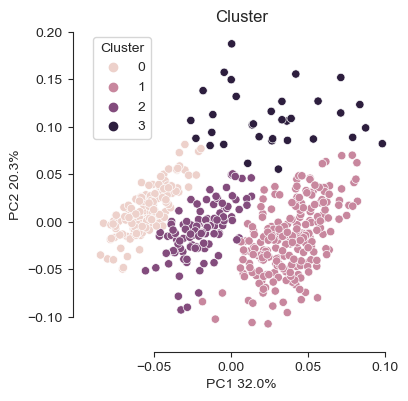

In [23]:
from sklearn.mixture import GaussianMixture
X = pca_2.iloc[:,1:3].values
gm = GaussianMixture(n_components=4, random_state=0).fit(X)

pca_2['Cluster'] = gm.predict(X)

fig, axes  = plt.subplots(figsize = (4,4))
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "Cluster", legend = True).set_title('Cluster')
sns.despine(offset=10, trim=True)

##### UMAP

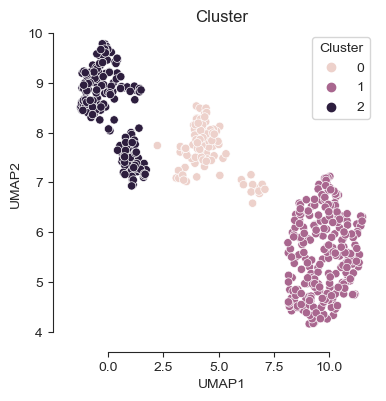

In [40]:
gm = GaussianMixture(n_components=3, random_state=0).fit(X)
X = sc_emb.iloc[:,0:2].values
sc_emb['Cluster'] = gm.predict(X)

fig, axes  = plt.subplots(figsize = (4,4))
sns.scatterplot(data = sc_emb, x = 'UMAP1', y = 'UMAP2', hue = 'Cluster', legend = True).set_title('Cluster')
sns.despine(offset=10, trim=True)

##### Check how the clustering agrees

In [25]:
sc.iloc[np.where(sc['PG.Genes'].str.contains('Dnmt3') == True)[0],0:2]

PG.ProteinGroups PG.Genes
120   O88508;O88508-2   Dnmt3a
1437           Q9CWR8   Dnmt3l

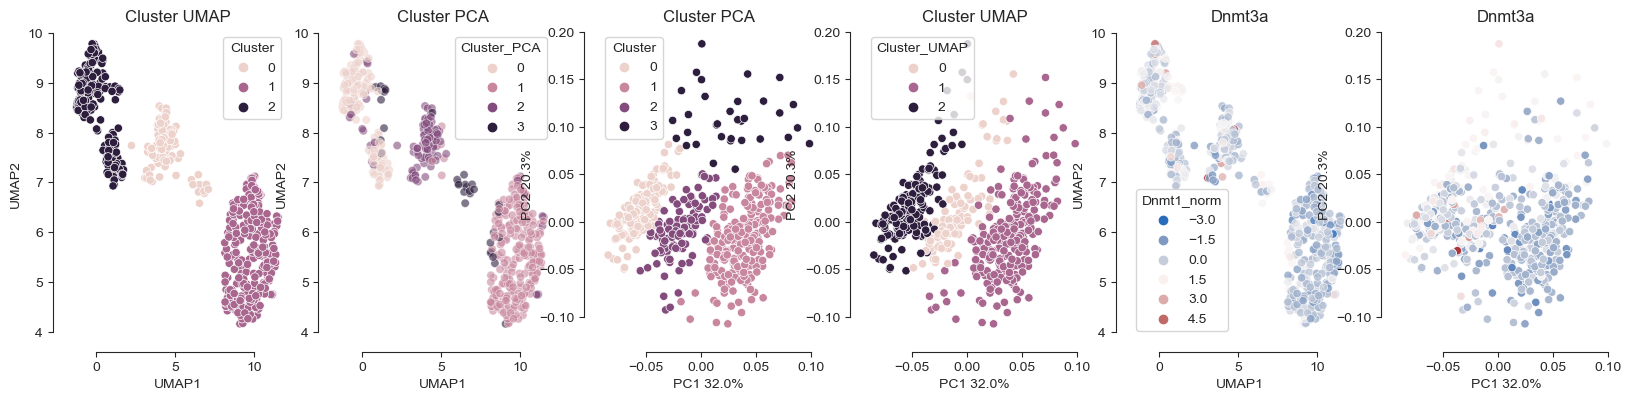

In [41]:
pca_2['Cluster_UMAP'] = sc_emb['Cluster'].values
sc_emb['Cluster_PCA'] = pca_2['Cluster'].values

temp = quant_filtered.apply(lambda x: (x - np.mean(x))/np.std(x),axis = 0)
temp = temp.apply(lambda x: (x - np.mean(x))/np.std(x),axis = 1)

test_protein = 'O88508;O88508-2'
#test_protein = 'P85965;Q9CQS7'
#test_protein = glyco_acc[4]
sc_emb['Dnmt1_norm'] = temp.loc[temp.index == test_protein,:].values[0]
pca_2['Dnmt1_norm'] = temp.loc[temp.index == test_protein,:].values[0]
sc_emb['Dnmt1'] = np.log2(quant_filtered.loc[quant_filtered.index == test_protein,:].values[0])
pca_2['Dnmt1'] = np.log2(quant_filtered.loc[quant_filtered.index == test_protein,:].values[0])
#sc_emb['Glud1'] = temp.loc[quant_filtered.index == 'P35492',:].values[0]

fig, axes  = plt.subplots(1,6, figsize = (20,4))
sns.scatterplot(data = sc_emb, x = 'UMAP1', y = 'UMAP2', hue = 'Cluster', legend = True, ax = axes[0]).set_title('Cluster UMAP')
sns.scatterplot(data = sc_emb, x = 'UMAP1', y = 'UMAP2', hue = 'Cluster_PCA', legend = True, ax = axes[1], alpha = 0.6).set_title('Cluster PCA')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "Cluster", legend = True, ax = axes[2]).set_title('Cluster PCA')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "Cluster_UMAP", legend = True, ax= axes[3]).set_title('Cluster UMAP')
sns.scatterplot(data = sc_emb, x = 'UMAP1', y = 'UMAP2', hue = "Dnmt1_norm", legend = True, palette = 'vlag', ax= axes[4], alpha =0.8).set_title('Dnmt3a')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "Dnmt1_norm", palette = 'vlag', legend = False, ax= axes[5]).set_title('Dnmt3a')
sns.despine(offset=10, trim=True)

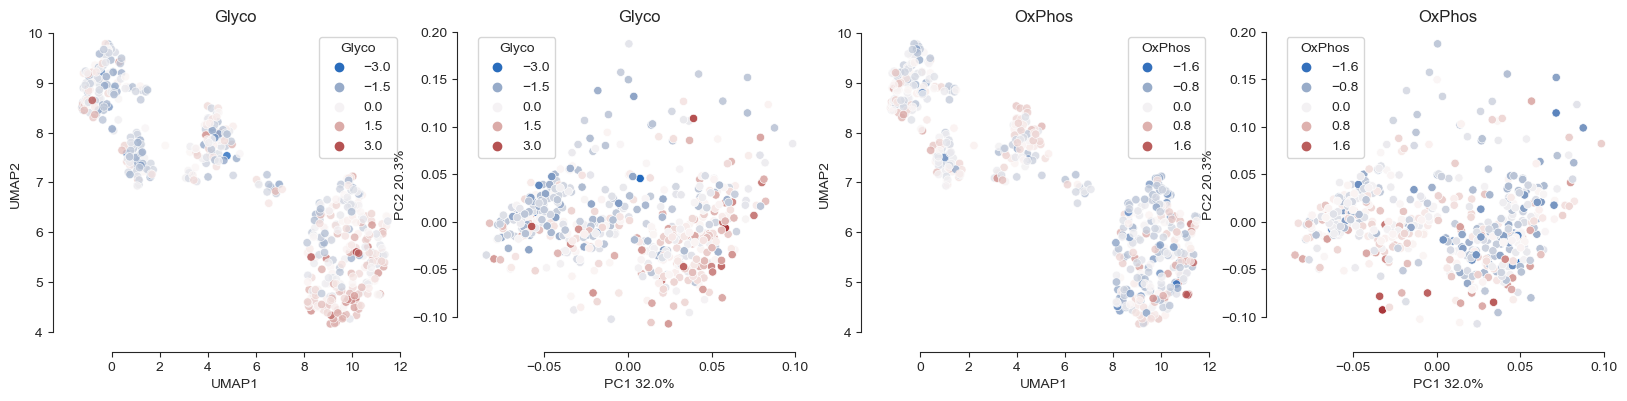

In [42]:
#Glycolysis 
glyco = pd.read_csv('data/MESC/glycolysis.txt')
oxPhos = pd.read_csv('data/MESC/OxPhos.txt')
tca = pd.read_csv('data/MESC/tca.txt')


glyco_acc = acc_genes.loc[acc_genes['PG.Genes'].isin(glyco.GeneSymbol.values),'PG.ProteinGroups'].values
oxPhos_acc = acc_genes.loc[acc_genes['PG.Genes'].isin(oxPhos.GeneSymbol.values),'PG.ProteinGroups'].values
tca_acc = acc_genes.loc[acc_genes['PG.Genes'].isin(tca.GeneSymbol.values),'PG.ProteinGroups'].values

#Score each cell by aggregating the values of each protein 

data = np.log2(quant_filtered).apply(lambda x: (x - np.nanmedian(x))/stats.median_abs_deviation(x), axis = 0)
#data = quant_filtered.apply(lambda x: (x - np.mean(x))/np.std(x),axis = 0)
#data = data.apply(lambda x: (x - np.mean(x))/np.std(x),axis = 1)
data = data.apply(lambda x: (x - np.nanmedian(x))/stats.median_abs_deviation(x),axis = 1)

data_glyco = data.loc[data.index.isin(glyco_acc),:].mean().values
data_oxPhos = data.loc[data.index.isin(oxPhos_acc),:].mean().values

pca_2['Glyco'] = data_glyco
pca_2['OxPhos'] = data_oxPhos

sc_emb['Glyco'] = data_glyco
sc_emb['OxPhos'] = data_oxPhos

fig, axes  = plt.subplots(1,4, figsize = (20,4))
sns.scatterplot(data = sc_emb, x = 'UMAP1', y = 'UMAP2', hue = "Glyco", legend = True, palette = 'vlag', ax= axes[0], alpha =0.8).set_title('Glyco')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "Glyco", palette = 'vlag', legend = True, ax= axes[1]).set_title('Glyco')
sns.scatterplot(data = sc_emb, x = 'UMAP1', y = 'UMAP2', hue = "OxPhos", legend = True, palette = 'vlag', ax= axes[2], alpha =0.8).set_title('OxPhos')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "OxPhos", palette = 'vlag', legend = True, ax= axes[3]).set_title('OxPhos')
sns.despine(offset=10, trim=True)

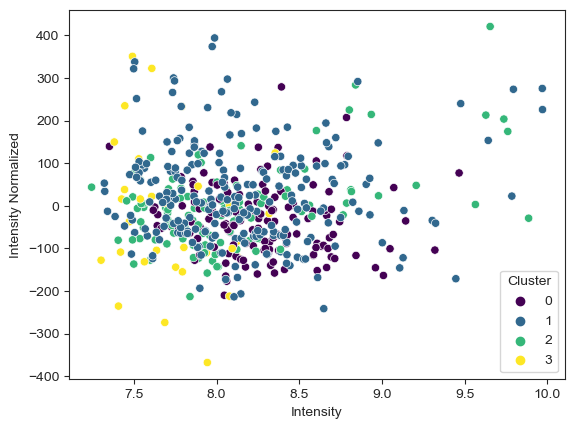

In [43]:
g = sns.scatterplot(data = pca_2, x = 'Intensity', y = 'Intensity Normalized', hue = 'Cluster', palette = 'viridis')

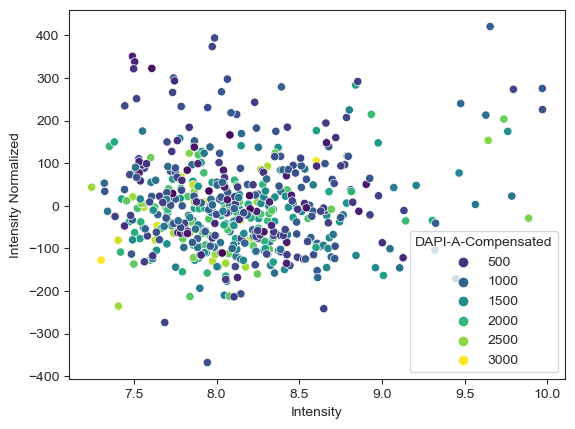

In [44]:
g = sns.scatterplot(data = pca_2, x = 'Intensity', y = 'Intensity Normalized', hue = 'DAPI-A-Compensated', palette = 'viridis')

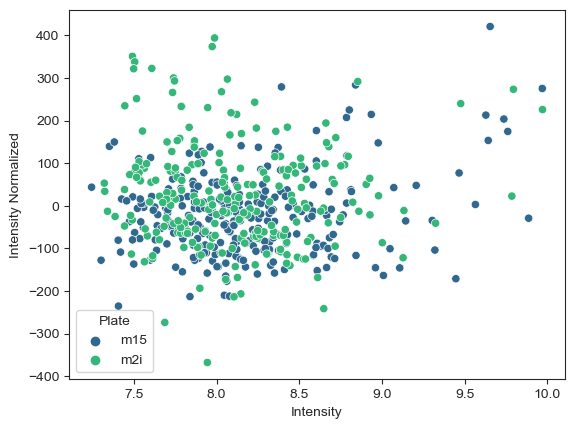

In [45]:
g = sns.scatterplot(data = pca_2, x = 'Intensity', y = 'Intensity Normalized', hue = 'Plate', palette = 'viridis')

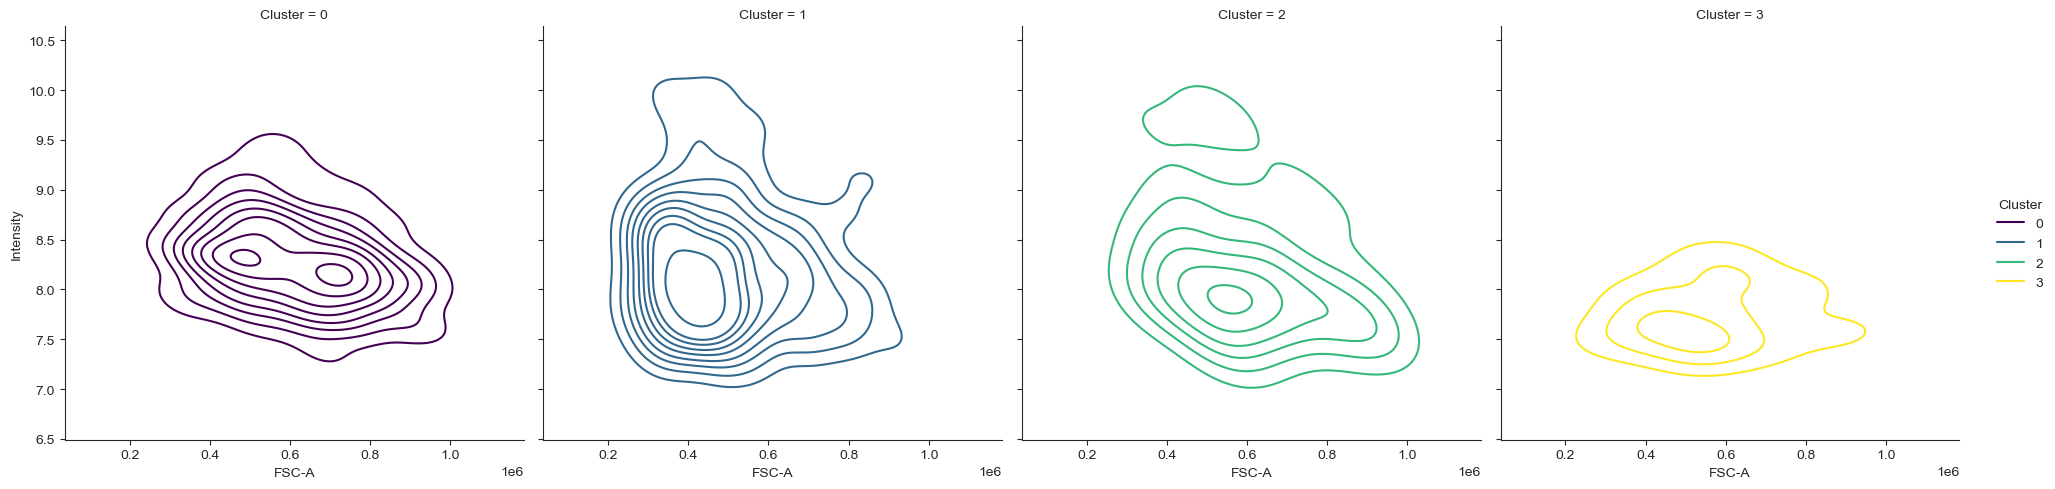

In [46]:
sns.displot(data = pca_2, x = 'FSC-A', y ='Intensity', hue = 'Cluster', palette = 'viridis', kind= 'kde', col= 'Cluster')

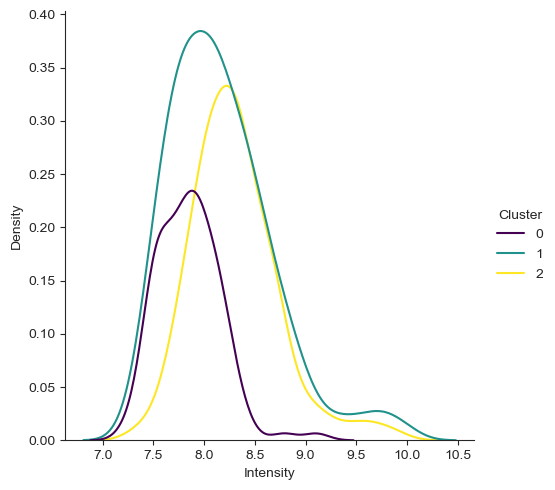

In [47]:
sns.displot(data = sc_emb, x = 'Intensity', hue = 'Cluster', palette = 'viridis', kind='kde')

/var/folders/fk/ycgfqq1520l3t9l7gs4wsjyr0000gp/T/ipykernel_5139/4224782748.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pmap.Cluster[pca_2.Cluster == 3] = 4


<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

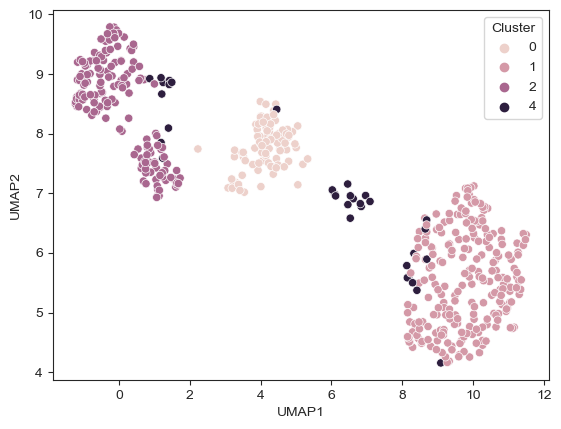

In [48]:
#Make a joing clustering based on the UMAP and PCA 

pmap = sc_emb
pmap.Cluster[pca_2.Cluster == 3] = 4


sns.scatterplot(data = pmap, x = 'UMAP1', y = 'UMAP2', hue = 'Cluster', legend = True)

#### Check if there are any biases in the abundance distributions based on the clusters 

In [49]:
pre_cluster = pre.merge(pmap, left_on = 'variable', right_on = 'File_Name').drop('File_Name', axis = 1)
post_cluster = post.merge(pmap, left_on = 'variable', right_on = 'File_Name').drop('File_Name', axis = 1)

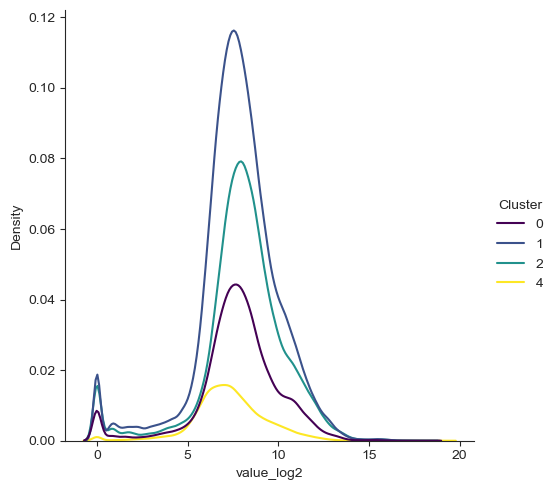

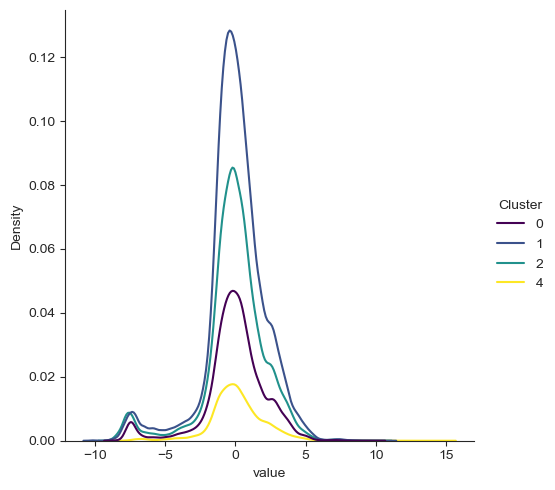

In [50]:
sns.displot(data=pre_cluster, x = 'value_log2', palette= "viridis", hue = 'Cluster', kind = 'kde')
sns.displot(data=post_cluster, x = 'value', palette= "viridis", hue = 'Cluster', kind = 'kde')

<AxesSubplot:xlabel='value', ylabel='Percent'>

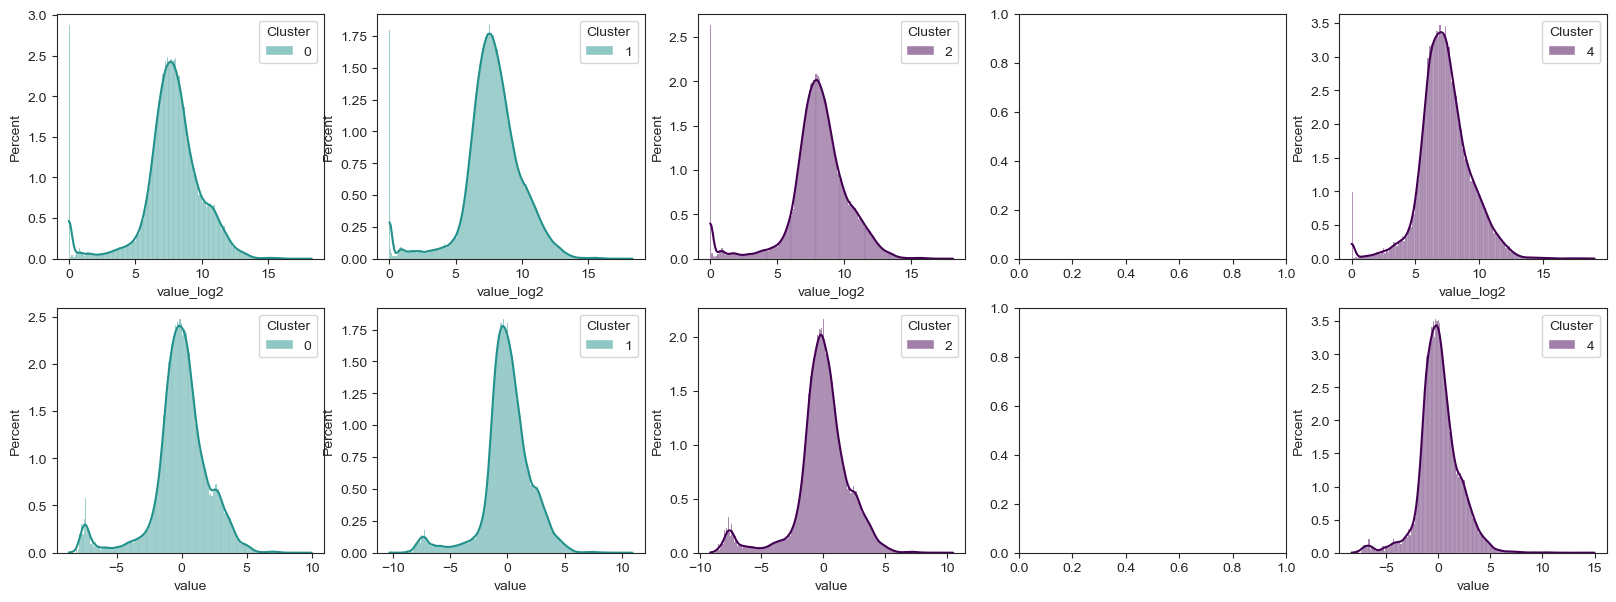

In [51]:
#sns.displot(data=pre_cluster, x = 'value_log2', palette= "viridis", col = 'Cluster', kind = 'hist', stat = 'percent')
#sns.displot(data=post_cluster, x = 'value', palette= "viridis", hue = 'Cluster', kind = 'hist')

fig, axes = plt.subplots(2,5, figsize=(20,7))
sns.histplot(data=pre_cluster.loc[pre_cluster.Cluster == 0,:], x = 'value_log2', palette= "viridis", hue = 'Cluster', kde = True, stat = 'percent', ax = axes[0,0], fill = 'False')
sns.histplot(data=pre_cluster.loc[pre_cluster.Cluster == 1,:], x = 'value_log2', palette= "viridis", hue = 'Cluster', kde = True, stat = 'percent', ax = axes[0,1], fill = 'False')
sns.histplot(data=pre_cluster.loc[pre_cluster.Cluster == 2,:], x = 'value_log2', palette= "viridis", hue = 'Cluster', kde = True, stat = 'percent', ax = axes[0,2], fill = 'False')
sns.histplot(data=pre_cluster.loc[pre_cluster.Cluster == 3,:], x = 'value_log2', palette= "viridis", hue = 'Cluster', kde = True, stat = 'percent', ax = axes[0,3], fill = 'False')
sns.histplot(data=pre_cluster.loc[pre_cluster.Cluster == 4,:], x = 'value_log2', palette= "viridis", hue = 'Cluster', kde = True, stat = 'percent', ax = axes[0,4], fill = 'False')

sns.histplot(data=post_cluster.loc[post_cluster.Cluster == 0,:], x = 'value', palette= "viridis", hue = 'Cluster', kde = True, stat = 'percent', ax = axes[1,0])
sns.histplot(data=post_cluster.loc[post_cluster.Cluster == 1,:], x = 'value', palette= "viridis", hue = 'Cluster', kde = True, stat = 'percent', ax = axes[1,1])
sns.histplot(data=post_cluster.loc[post_cluster.Cluster == 2,:], x = 'value', palette= "viridis", hue = 'Cluster', kde = True, stat = 'percent', ax = axes[1,2])
sns.histplot(data=post_cluster.loc[post_cluster.Cluster == 3,:], x = 'value', palette= "viridis", hue = 'Cluster', kde = True, stat = 'percent', ax = axes[1,3])
sns.histplot(data=post_cluster.loc[post_cluster.Cluster == 4,:], x = 'value', palette= "viridis", hue = 'Cluster', kde = True, stat = 'percent', ax = axes[1,4])

<AxesSubplot:xlabel='DAPI-A-Compensated', ylabel='Intensity Normalized'>

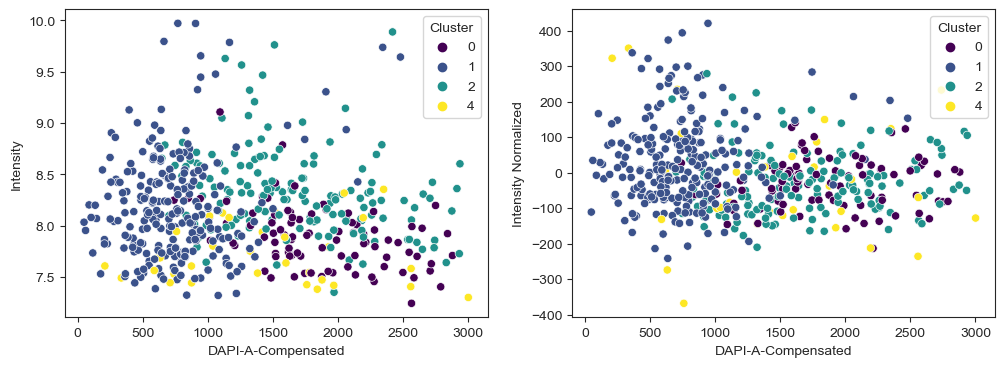

In [52]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.scatterplot(data=pmap, x ='DAPI-A-Compensated', y = 'Intensity', hue='Cluster', palette = 'viridis', ax = axes[0])
sns.scatterplot(data=pmap, x ='DAPI-A-Compensated', y = 'Intensity Normalized', hue='Cluster', palette = 'viridis', ax = axes[1])

#### Identify proteins that have different distributions between the clusters 

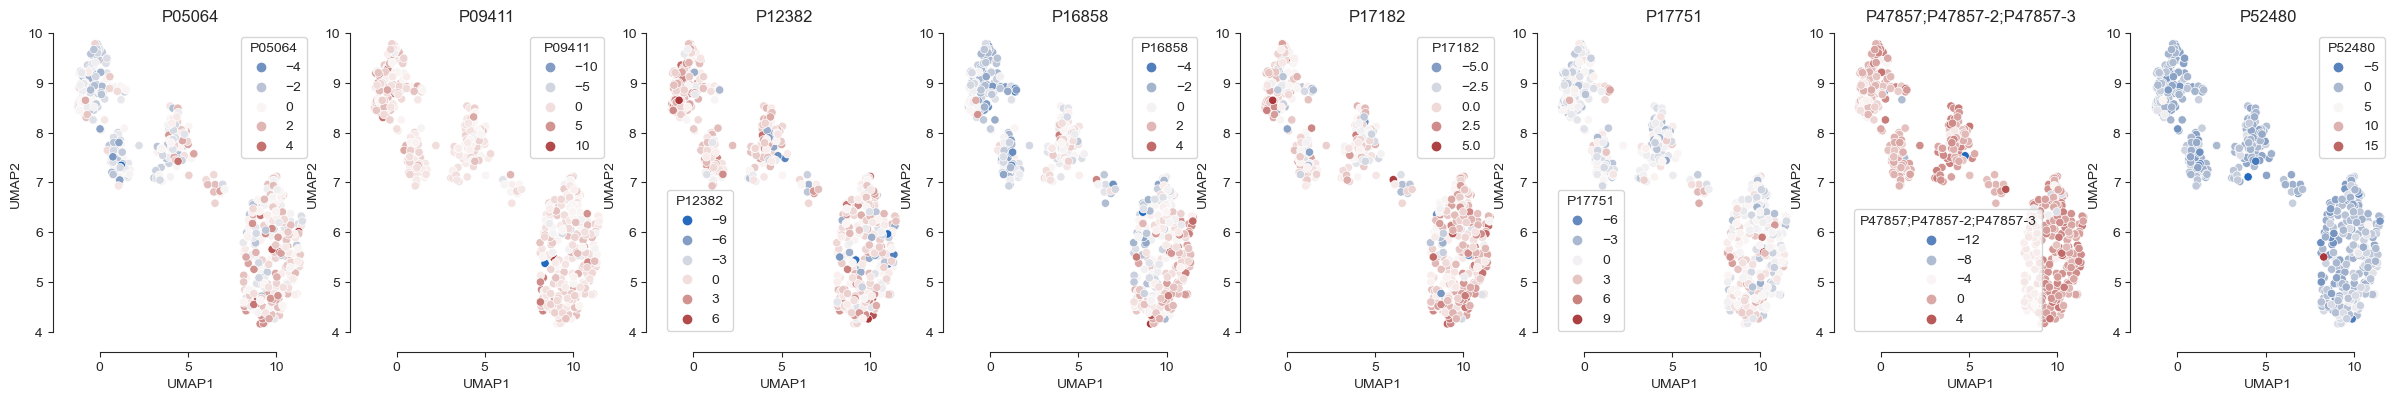

In [53]:
#Combine the data for calculation 

glyco_data = data.loc[data.index.isin(glyco_acc)].T.reset_index()

pmap_quant = pmap.merge(glyco_data, left_on='File_Name', right_on = 'index').drop(['index','File_Name'], axis = 1)

glyco_acc2 = glyco_acc[np.isin(glyco_acc, data.index.values)]

fig, axes  = plt.subplots(1,8, figsize = (30,4))
for i in range(8):
    sns.scatterplot(data = pmap_quant, x = 'UMAP1', y = 'UMAP2', hue = glyco_acc2[i], legend = True, palette='vlag', ax = axes[i]).set_title(glyco_acc2[i])

sns.despine(offset=10, trim=True)

In [54]:
glyco_acc2

array(['P05064', 'P09411', 'P12382', 'P16858', 'P17182', 'P17751',
       'P47857;P47857-2;P47857-3', 'P52480'], dtype=object)

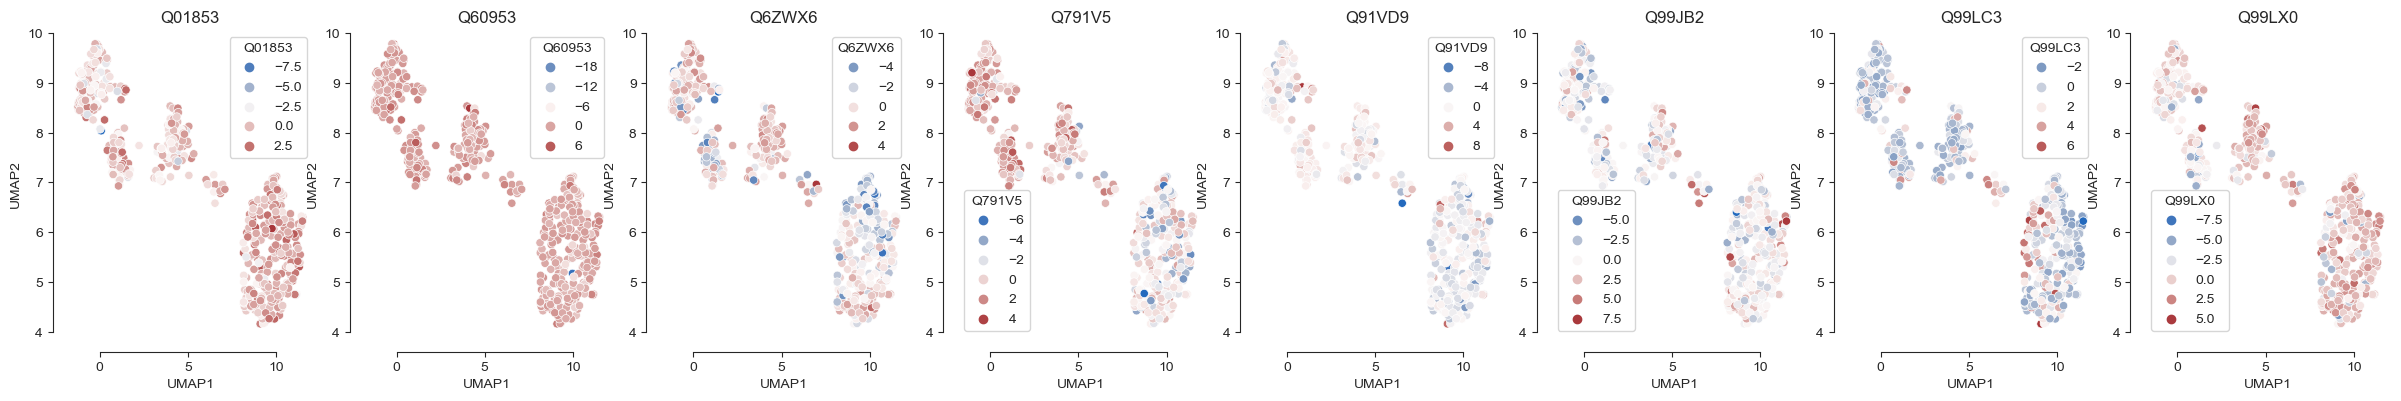

In [55]:
#Combine the data for calculation 

oxPhos_data = data.loc[data.index.isin(oxPhos_acc)].T.reset_index()

pmap_oxPhos = pmap.merge(oxPhos_data, left_on='File_Name', right_on = 'index').drop(['index','File_Name'], axis = 1)

oxPhos_acc2 = oxPhos_acc[np.isin(oxPhos_acc, data.index.values)]

fig, axes  = plt.subplots(1,8, figsize = (30,4))
j= 14
for i in range(8):
    sns.scatterplot(data = pmap_oxPhos, x = 'UMAP1', y = 'UMAP2', hue = oxPhos_acc2[i+j], legend = True, palette='vlag', ax = axes[i]).set_title(oxPhos_acc2[i+j])

sns.despine(offset=10, trim=True)

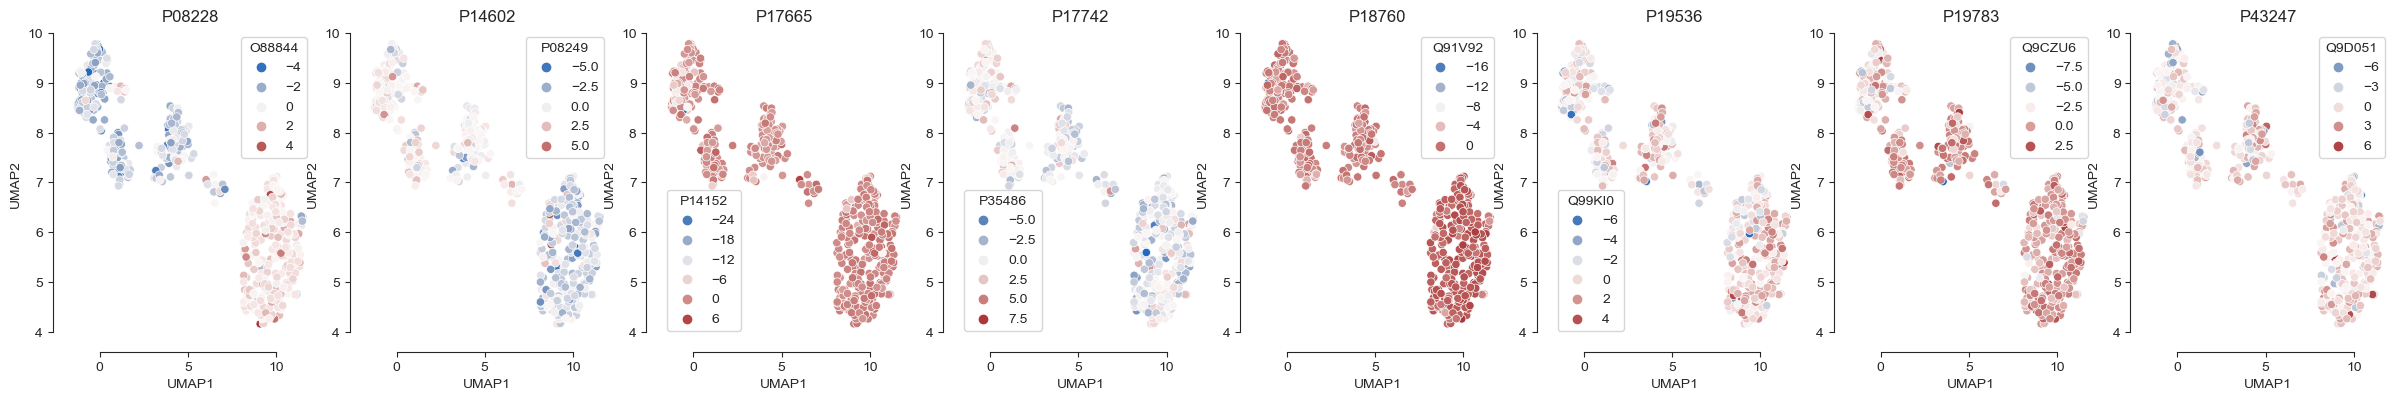

In [56]:
tca_data = data.loc[data.index.isin(tca_acc)].T.reset_index()

pmap_oxPhos = pmap.merge(tca_data, left_on='File_Name', right_on = 'index').drop(['index','File_Name'], axis = 1)

tca_acc2 = tca_acc[np.isin(tca_acc, data.index.values)]

fig, axes  = plt.subplots(1,8, figsize = (30,4))
j= 0
for i in range(8):
    sns.scatterplot(data = pmap_oxPhos, x = 'UMAP1', y = 'UMAP2', hue = tca_acc2[i+j], legend = True, palette='vlag', ax = axes[i]).set_title(oxPhos_acc2[i+j])

sns.despine(offset=10, trim=True)

In [57]:
tca_acc2

array(['O88844', 'P08249', 'P14152', 'P35486', 'Q91V92', 'Q99KI0',
       'Q9CZU6', 'Q9D051', 'Q9D2G2', 'Q9D6R2'], dtype=object)

In [58]:
#sns.displot(pmap_quant, x = glyco_acc2[3], hue = 'Cluster', kind = 'hist', stat= 'percent', palette = 'viridis')
#sns.displot(pmap_quant, x = glyco_acc2[1], hue = 'Cluster', kind = 'kde', palette = 'viridis')
#sns.displot(pmap_quant, x = 'OxPhos', hue = 'Plate', kind = 'kde', palette = 'viridis')

#### Geneset enrichment analysis

In [59]:
import gseapy as gp
from gseapy import Biomart

In [60]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbations_GEO_2022',
 'DisGeNET',
 'Disease_

In [61]:
## Get human orthologs for the mouse genes 
bm = Biomart()
# note the dataset and attribute names are different
m2h = bm.query(dataset='mmusculus_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'hsapiens_homolog_ensembl_gene',
                           'hsapiens_homolog_associated_gene_name'])

In [62]:
#Get the filtered gene list 
ids = acc_genes.loc[acc_genes['PG.ProteinGroups'].isin(quant_filtered.index.values),:]
#Filter out all the undetected genes from the biomart table
m2h_filtered = m2h.loc[m2h.external_gene_name.isin(ids['PG.Genes'].values),:]
m2h_filtered = m2h_filtered.loc[m2h_filtered.external_gene_name.isna() == False,:]
##Lost ~60 proteins somewhere, probably the multi ID ones
m2h_filtered = m2h_filtered.merge(ids, right_on = 'PG.Genes', left_on ='external_gene_name').drop('PG.Genes', axis = 1)
m2h_filtered

ensembl_gene_id external_gene_name hsapiens_homolog_ensembl_gene  \
0     ENSMUSG00000024590              Lmnb1               ENSG00000113368   
1     ENSMUSG00000024306            Ccdc178               ENSG00000166960   
2     ENSMUSG00000006456              Rbm14               ENSG00000239306   
3     ENSMUSG00000024608              Rps14               ENSG00000164587   
4     ENSMUSG00000022982               Sod1               ENSG00000142168   
...                  ...                ...                           ...   
1031  ENSMUSG00000054455               Vapb               ENSG00000124164   
1032  ENSMUSG00000026817                Ak1               ENSG00000106992   
1033  ENSMUSG00000009555               Cdk9               ENSG00000136807   
1034  ENSMUSG00000034075             Zdhhc5               ENSG00000156599   
1035  ENSMUSG00000027597               Ahcy               ENSG00000101444   

     hsapiens_homolog_associated_gene_name          PG.ProteinGroups  
0                                    LMNB1                    P14733  
1                                  CCDC178                    Q8CDV0  
2                                    RBM14                    Q8C2Q3  
3                                    RPS14                    P62264  
4                                     SOD1                    P08228  
...                                    ...                       ...  
1031                                  VAPB                    Q9QY76  
1032                                   AK1           Q9R0Y5;Q9R0Y5-2  
1033                                  CDK9  Q99J95;Q99J95-2;Q99J95-3  
1034                                ZDHHC5           Q8VDZ4;Q8VDZ4-2  
1035                                  AHCY                    P50247  

[1036 rows x 5 columns]

In [63]:
cellType = list(pca_2.Plate.values)
#gsea_data = np.log2(quant_filtered)
gsea_data = np.log2(quant_filtered).apply(lambda x: (x - np.nanmedian(x))/stats.median_abs_deviation(x), axis = 0)
gsea_data  = gsea_data .apply(lambda x: (x - np.nanmedian(x))/stats.median_abs_deviation(x),axis = 1)
gsea_data = gsea_data.reset_index().merge(m2h_filtered, on = 'PG.ProteinGroups')
gsea_data.insert(0, 'NAME',  gsea_data.hsapiens_homolog_associated_gene_name) 
gsea_data = gsea_data.drop(['ensembl_gene_id',	'external_gene_name',	'hsapiens_homolog_ensembl_gene',	'hsapiens_homolog_associated_gene_name',	'PG.ProteinGroups'], axis = 1)
gsea_data.insert(1, 'DESCRIPTION', np.nan) 
#Remove some genes that have NA 
gsea_data = gsea_data.loc[gsea_data.NAME.isna() == False]

In [64]:
gs_res = gp.gsea(data=gsea_data,
                 gene_sets='MSigDB_Hallmark_2020', # or enrichr library names
                 cls= cellType, # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=1000, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 method='signal_to_noise',
                 threads=4, seed= 42)
gs_res.res2d.head(20)

2023-07-06 21:53:49,987 [WARNING] Dropping duplicated gene names, only keep the first values
2023-07-06 21:53:49,996 [WARNING] Input data contains NA, filled NA with 0


Name                       Term        ES       NES NOM p-val FDR q-val  \
0   gsea                  Apoptosis -0.573245 -1.773777   0.00202  0.075898   
1   gsea                Pperoxisome -0.588212 -1.692343  0.022587  0.092854   
2   gsea               Adipogenesis -0.499246 -1.660104  0.012024  0.078051   
3   gsea      Xenobiotic Metabolism -0.547792  -1.62209  0.026263  0.076302   
4   gsea      Fatty Acid Metabolism -0.499419 -1.611164  0.014614  0.066209   
5   gsea                 Glycolysis -0.484824 -1.609891  0.018789  0.055713   
6   gsea             Myc Targets V2  0.487667  1.538582  0.031621  0.148633   
7   gsea        Allograft Rejection -0.517617 -1.517777  0.043388  0.093892   
8   gsea           mTORC1 Signaling -0.361545 -1.496083  0.023392  0.094873   
9   gsea             UV Response Up -0.448029 -1.494341  0.056112  0.086126   
10  gsea  Oxidative Phosphorylation  0.427478  1.442265  0.091463  0.135553   
11  gsea                E2F Targets -0.376468 -1.438337  0.047035  0.108034   
12  gsea          Protein Secretion -0.371446 -1.172797  0.252988  0.354534   
13  gsea                    Hypoxia -0.364989 -1.083141  0.371257  0.460503   
14  gsea            Mitotic Spindle -0.316235 -1.075741  0.340681  0.436632   
15  gsea            G2-M Checkpoint -0.270609 -1.035796  0.406852  0.460119   
16  gsea  Unfolded Protein Response -0.306456 -1.033416   0.37451  0.433212   
17  gsea                 DNA Repair -0.295296  -0.95475  0.552419  0.514332   
18  gsea            Apical Junction    0.2918  0.878285  0.652263  0.852556   
19  gsea             Myc Targets V1  0.188481  0.772425  0.834661  0.790824   

   FWER p-val   Tag %  Gene %  \
0       0.043    8/21  12.60%   
1       0.103    6/17  14.72%   
2       0.131   11/27  17.04%   
3       0.164    8/19  16.63%   
4       0.177   12/29  17.24%   
5       0.179   10/30  12.80%   
6       0.279   10/24  15.93%   
7       0.307    5/16  15.62%   
8       0.344   29/76  38.31%   
9       0.351   11/26  25.00%   
10      0.436   22/47  18.25%   
11      0.437   30/60  41.33%   
12      0.839    9/23  28.33%   
13      0.918    8/19  27.92%   
14      0.922   18/29  41.43%   
15      0.949   28/53  43.35%   
16       0.95   13/30  34.78%   
17      0.978   10/22  47.38%   
18      0.993   19/19  96.57%   
19      0.998  71/127  46.07%   

                                           Lead_genes  
0          HMGB2;CASP3;RELA;GSR;BAX;IFITM3;SOD2;TOP2A  
1                     IDH1;FDPS;IDI1;SOD2;TOP2A;PRDX1  
2   IDH1;ACLY;QDPR;COL4A1;ALDOA;ACADM;G3BP2;TKT;CS...  
3             IDH1;PGD;GSR;NQO1;CYB5A;AHCY;ENPEP;ACO2  
4   IDH1;IDI1;HSP90AA1;HMGCS1;ALDOA;ACADM;ACAT2;MD...  
5   IDH1;FKBP4;STMN1;NASP;PGAM1;ALDOA;MDH1;ENO1;CY...  
6   HK2;NOP56;HSPD1;MRTO4;HSPE1;NOC4L;SRM;NOP2;WDR...  
7                       TPD52;AARS1;NLRP3;ABCE1;UBE2N  
8   IDH1;IDI1;ACLY;PSAT1;HMGCS1;GSR;SLC7A5;QDPR;SL...  
9   FKBP4;CASP3;PSMC3;CYB5B;ALDOA;ASNS;SOD2;TARS1;...  
10  GLUD1;NDUFA4;LDHA;HSPA9;MDH2;ATP5MF;COX7C;VDAC...  
11  PAICS;HMGB2;PSIP1;KPNA2;TUBB;PCNA;STMN1;NASP;B...  
12  TPD52;LMAN1;CLTC;AP2S1;MAPK1;AP3B1;STX12;SH3GL...  
13       TPD52;ALDOA;GAPDH;ENO1;TPI1;AKAP12;GRHPR;LOX  
14  BRCA2;YWHAE;SPTBN1;FSCN1;NDC80;TOP2A;KIF11;DYN...  
15  KPNA2;STMN1;NASP;SLC7A5;BRCA2;UPF1;POLQ;NDC80;...  
16  PSAT1;LSM4;SLC7A5;EIF4EBP1;KHSRP;ASNS;TARS1;EI...  
17  PCNA;AK1;ALYREF;SRSF6;LIG1;NCBP2;POLA1;FEN1;PO...  
18  ACTN4;ACTN1;ARPC2;GTF2F1;CTNNA1;PPP2R2C;CDH6;P...  
19  LDHA;SNRPA1;PABPC1;TUFM;NOP56;HSPD1;DDX21;HSPE...

In [65]:
#Extract the glycolysis and OxPhos proteins 
data = np.log2(quant_filtered).apply(lambda x: (x - np.nanmedian(x))/stats.median_abs_deviation(x), axis = 0)
data = data.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 1)


glyco_genes = gs_res.res2d.Lead_genes[gs_res.res2d.Term == 'Glycolysis'].values[0]
glyco_genes = np.concatenate([glyco_genes.split(';'),[x.upper() for x in glyco.GeneSymbol.values]])

oxphos_genes = gs_res.res2d.Lead_genes[gs_res.res2d.Term == 'Oxidative Phosphorylation'].values[0]
oxphos_genes = np.concatenate([oxphos_genes.split(';'), [x.upper() for x in oxPhos.GeneSymbol.values], [x.upper() for x in tca.GeneSymbol.values]])
oxphos_genes

extract_genes = np.concatenate([glyco_genes, oxphos_genes])

glyco_oxphos = m2h.loc[m2h.hsapiens_homolog_associated_gene_name.isin(extract_genes),:]

glyco_oxphos_acc_gene = acc_genes.loc[acc_genes['PG.Genes'].isin(glyco_oxphos.external_gene_name),:]

metabolism_data = glyco_oxphos_acc_gene.merge(data, left_on='PG.ProteinGroups', right_index=True)

#merge to embedding dataframe for visualization 
#Combine the data for calculation 

metabolism_data = metabolism_data.T

metabolism_data.columns = metabolism_data.iloc[1,:]
metabolism_data = metabolism_data.iloc[2:,:]

pmap_metabolism = pmap.drop('Glud1', axis=1).merge(metabolism_data, left_on='File_Name', right_index = True)
pmap_metabolism



UMAP1     UMAP2                                          File_Name  \
0     4.013513  8.294025  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
1     0.699618  8.905088  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
2     0.280513  8.681312  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
3    -0.280279  8.544475  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
4     2.226473  7.743897  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
..         ...       ...                                                ...   
515  10.808461  6.371929  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
516  11.245189  5.672690  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
517  10.157985  6.195972  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
518   9.977836  6.410796  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
519  10.797932  5.288779  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   

       CellID  Detected_Proteins  Intensity CellType  QC_Pass Position  \
0      cell_1               1140   7.493173      m15     True      A10   
1      cell_2                726   8.367414      m15     True      E12   
2      cell_3                950   8.050534      m15     True      E13   
3      cell_4                994   8.056626      m15     True      E14   
4      cell_5               1165   7.559803      m15     True      E15   
..        ...                ...        ...      ...      ...      ...   
515  cell_604                709   8.433825      m2i     True       E7   
516  cell_605                728   8.477236      m2i     True       E8   
517  cell_606                904   8.038930      m2i     True       E9   
518  cell_607                822   8.302719      m2i     True      E10   
519  cell_608                957   8.144512      m2i     True      E11   

         TIME  ...      Nasp    Ndufa2   Uqcrfs1        Cs      Pdhb  \
0    175.4116  ... -0.246772  1.304986 -1.657423 -0.117451 -0.039723   
1    203.3616  ... -1.041712  0.935112  0.677545 -0.243643 -0.541957   
2    212.6815  ...  0.111937  0.151899 -0.059603 -0.177119 -0.335291   
3    236.4491  ... -0.245308  0.669324 -1.437487  -1.20907 -2.508156   
4    246.1141  ...  0.378585  0.927395 -0.484945  0.505576  0.083571   
..        ...  ...       ...       ...       ...       ...       ...   
515  105.8815  ...  0.678406 -0.474554  0.206992  0.296565 -0.247405   
516  129.7211  ...  1.974951 -0.183909  0.341472  1.071093  0.289109   
517  138.7414  ...  -0.21221 -0.750828   0.22038  0.829105  0.396488   
518  162.4921  ...  0.531807 -0.319163  0.278144 -0.626327  0.327764   
519  171.7456  ...  1.246127 -0.376838 -0.125604  1.073089  0.559602   

         Dlst     Idh3a     Atp5o    Uqcrc2     Pgam1  
0    0.554311  0.450809  0.608109 -0.578068  0.244873  
1     1.50699  0.961192 -1.643277 -0.252844  0.334392  
2    -0.79194   0.36782 -0.015032  0.505484 -1.268917  
3    0.927448  0.254014  0.403312  0.412975 -0.344192  
4    0.024713 -0.811548 -0.038909 -0.494817 -0.950688  
..        ...       ...       ...       ...       ...  
515 -0.040892 -0.855629 -3.222244  0.437306  1.787876  
516 -0.389919 -0.583463 -1.083074  0.156021  0.709897  
517  0.023791  0.041588 -1.137288  0.072122   1.54803  
518  0.056443 -0.829236 -0.582041 -0.381472  0.804943  
519 -0.516898  0.179168 -0.896261  0.239445  0.181853  

[520 rows x 86 columns]

In [66]:
glyco_oxphos['Glycolysis'] = glyco_oxphos.hsapiens_homolog_associated_gene_name.isin(glyco_genes)
glyco_oxphos['OxPhos'] = glyco_oxphos.hsapiens_homolog_associated_gene_name.isin(oxphos_genes)
glyco_oxphos

/var/folders/fk/ycgfqq1520l3t9l7gs4wsjyr0000gp/T/ipykernel_5139/1407655380.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glyco_oxphos['Glycolysis'] = glyco_oxphos.hsapiens_homolog_associated_gene_name.isin(glyco_genes)
/var/folders/fk/ycgfqq1520l3t9l7gs4wsjyr0000gp/T/ipykernel_5139/1407655380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glyco_oxphos['OxPhos'] = glyco_oxphos.hsapiens_homolog_associated_gene_name.isin(oxphos_genes)


ensembl_gene_id external_gene_name hsapiens_homolog_ensembl_gene  \
5      ENSMUSG00000064341             mt-Nd1               ENSG00000198888   
9      ENSMUSG00000064345             mt-Nd2               ENSG00000198763   
15     ENSMUSG00000064351             mt-Co1               ENSG00000198804   
18     ENSMUSG00000064354             mt-Co2               ENSG00000198712   
20     ENSMUSG00000064356            mt-Atp8               ENSG00000228253   
...                   ...                ...                           ...   
60827  ENSMUSG00000025488              Cox8b               ENSG00000187581   
61287  ENSMUSG00000027305            Ndufaf1               ENSG00000137806   
61501  ENSMUSG00000005510             Ndufs3               ENSG00000213619   
61525  ENSMUSG00000027406              Idh3b               ENSG00000101365   
61611  ENSMUSG00000025781             Atp5c1               ENSG00000165629   

      hsapiens_homolog_associated_gene_name  Glycolysis  OxPhos  
5                                    MT-ND1       False    True  
9                                    MT-ND2       False    True  
15                                   MT-CO1       False    True  
18                                   MT-CO2       False    True  
20                                  MT-ATP8       False    True  
...                                     ...         ...     ...  
60827                                 COX8C       False    True  
61287                               NDUFAF1       False    True  
61501                                NDUFS3       False    True  
61525                                 IDH3B       False    True  
61611                               ATP5F1C       False    True  

[343 rows x 6 columns]

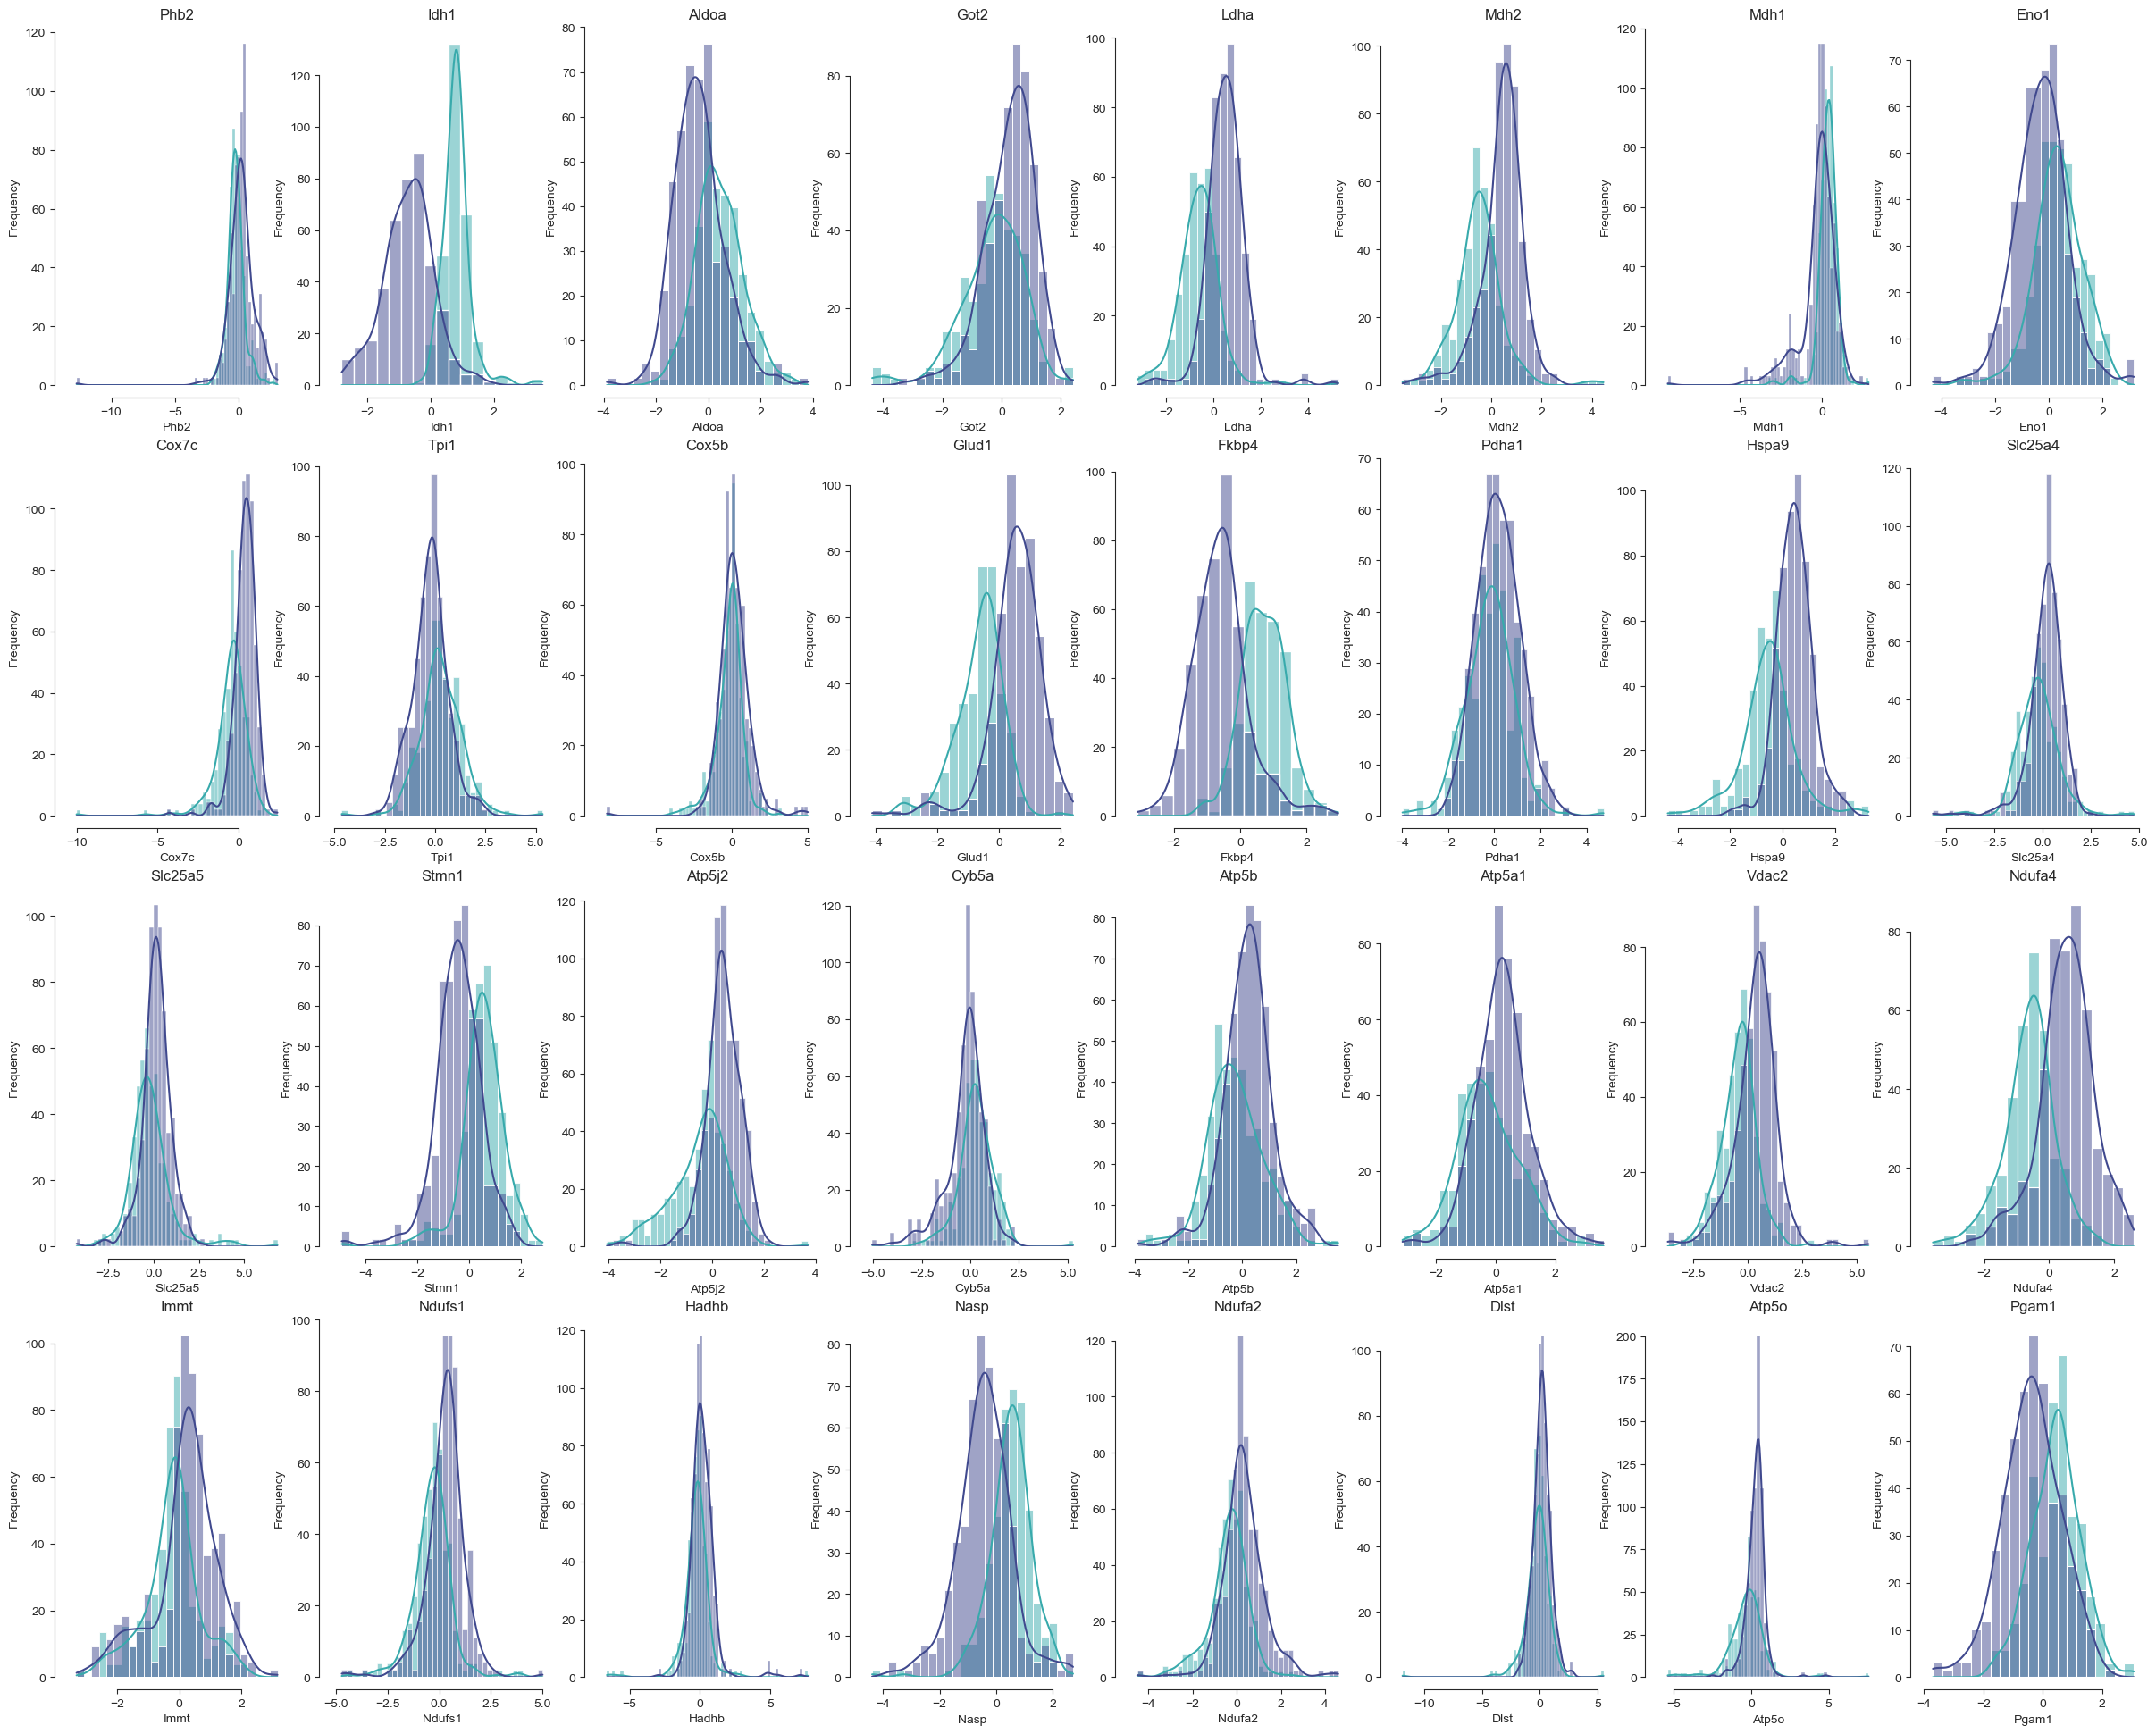

In [ ]:
fig, axes  = plt.subplots(4,8, figsize = (30,24))

i=0
for k, j in zip(glyco_oxphos_acc_gene['PG.Genes'].values ,np.tile(np.arange(0,8),4)):
    if i < 8:
        sns.histplot(data = pmap_metabolism, x = k, hue = 'Plate', legend = False, palette='mako', ax = axes[0,j], stat ='frequency', kde = True).set_title(k)
    elif (i > 7 and i < 16):
        sns.histplot(data = pmap_metabolism, x = k, hue = 'Plate', legend = False, palette='mako', ax = axes[1,j], stat ='frequency', kde = True).set_title(k)
    elif (i > 15 and i < 24):
        sns.histplot(data = pmap_metabolism, x = k, hue = 'Plate', legend = False, palette='mako', ax = axes[2,j], stat ='frequency', kde = True).set_title(k)
    elif (i > 23 and i < 33):
        sns.histplot(data = pmap_metabolism, x = k, hue = 'Plate', legend = False, palette='mako', ax = axes[3,j], stat ='frequency', kde = True).set_title(k)
    i+=1
sns.despine(offset=10, trim=True)

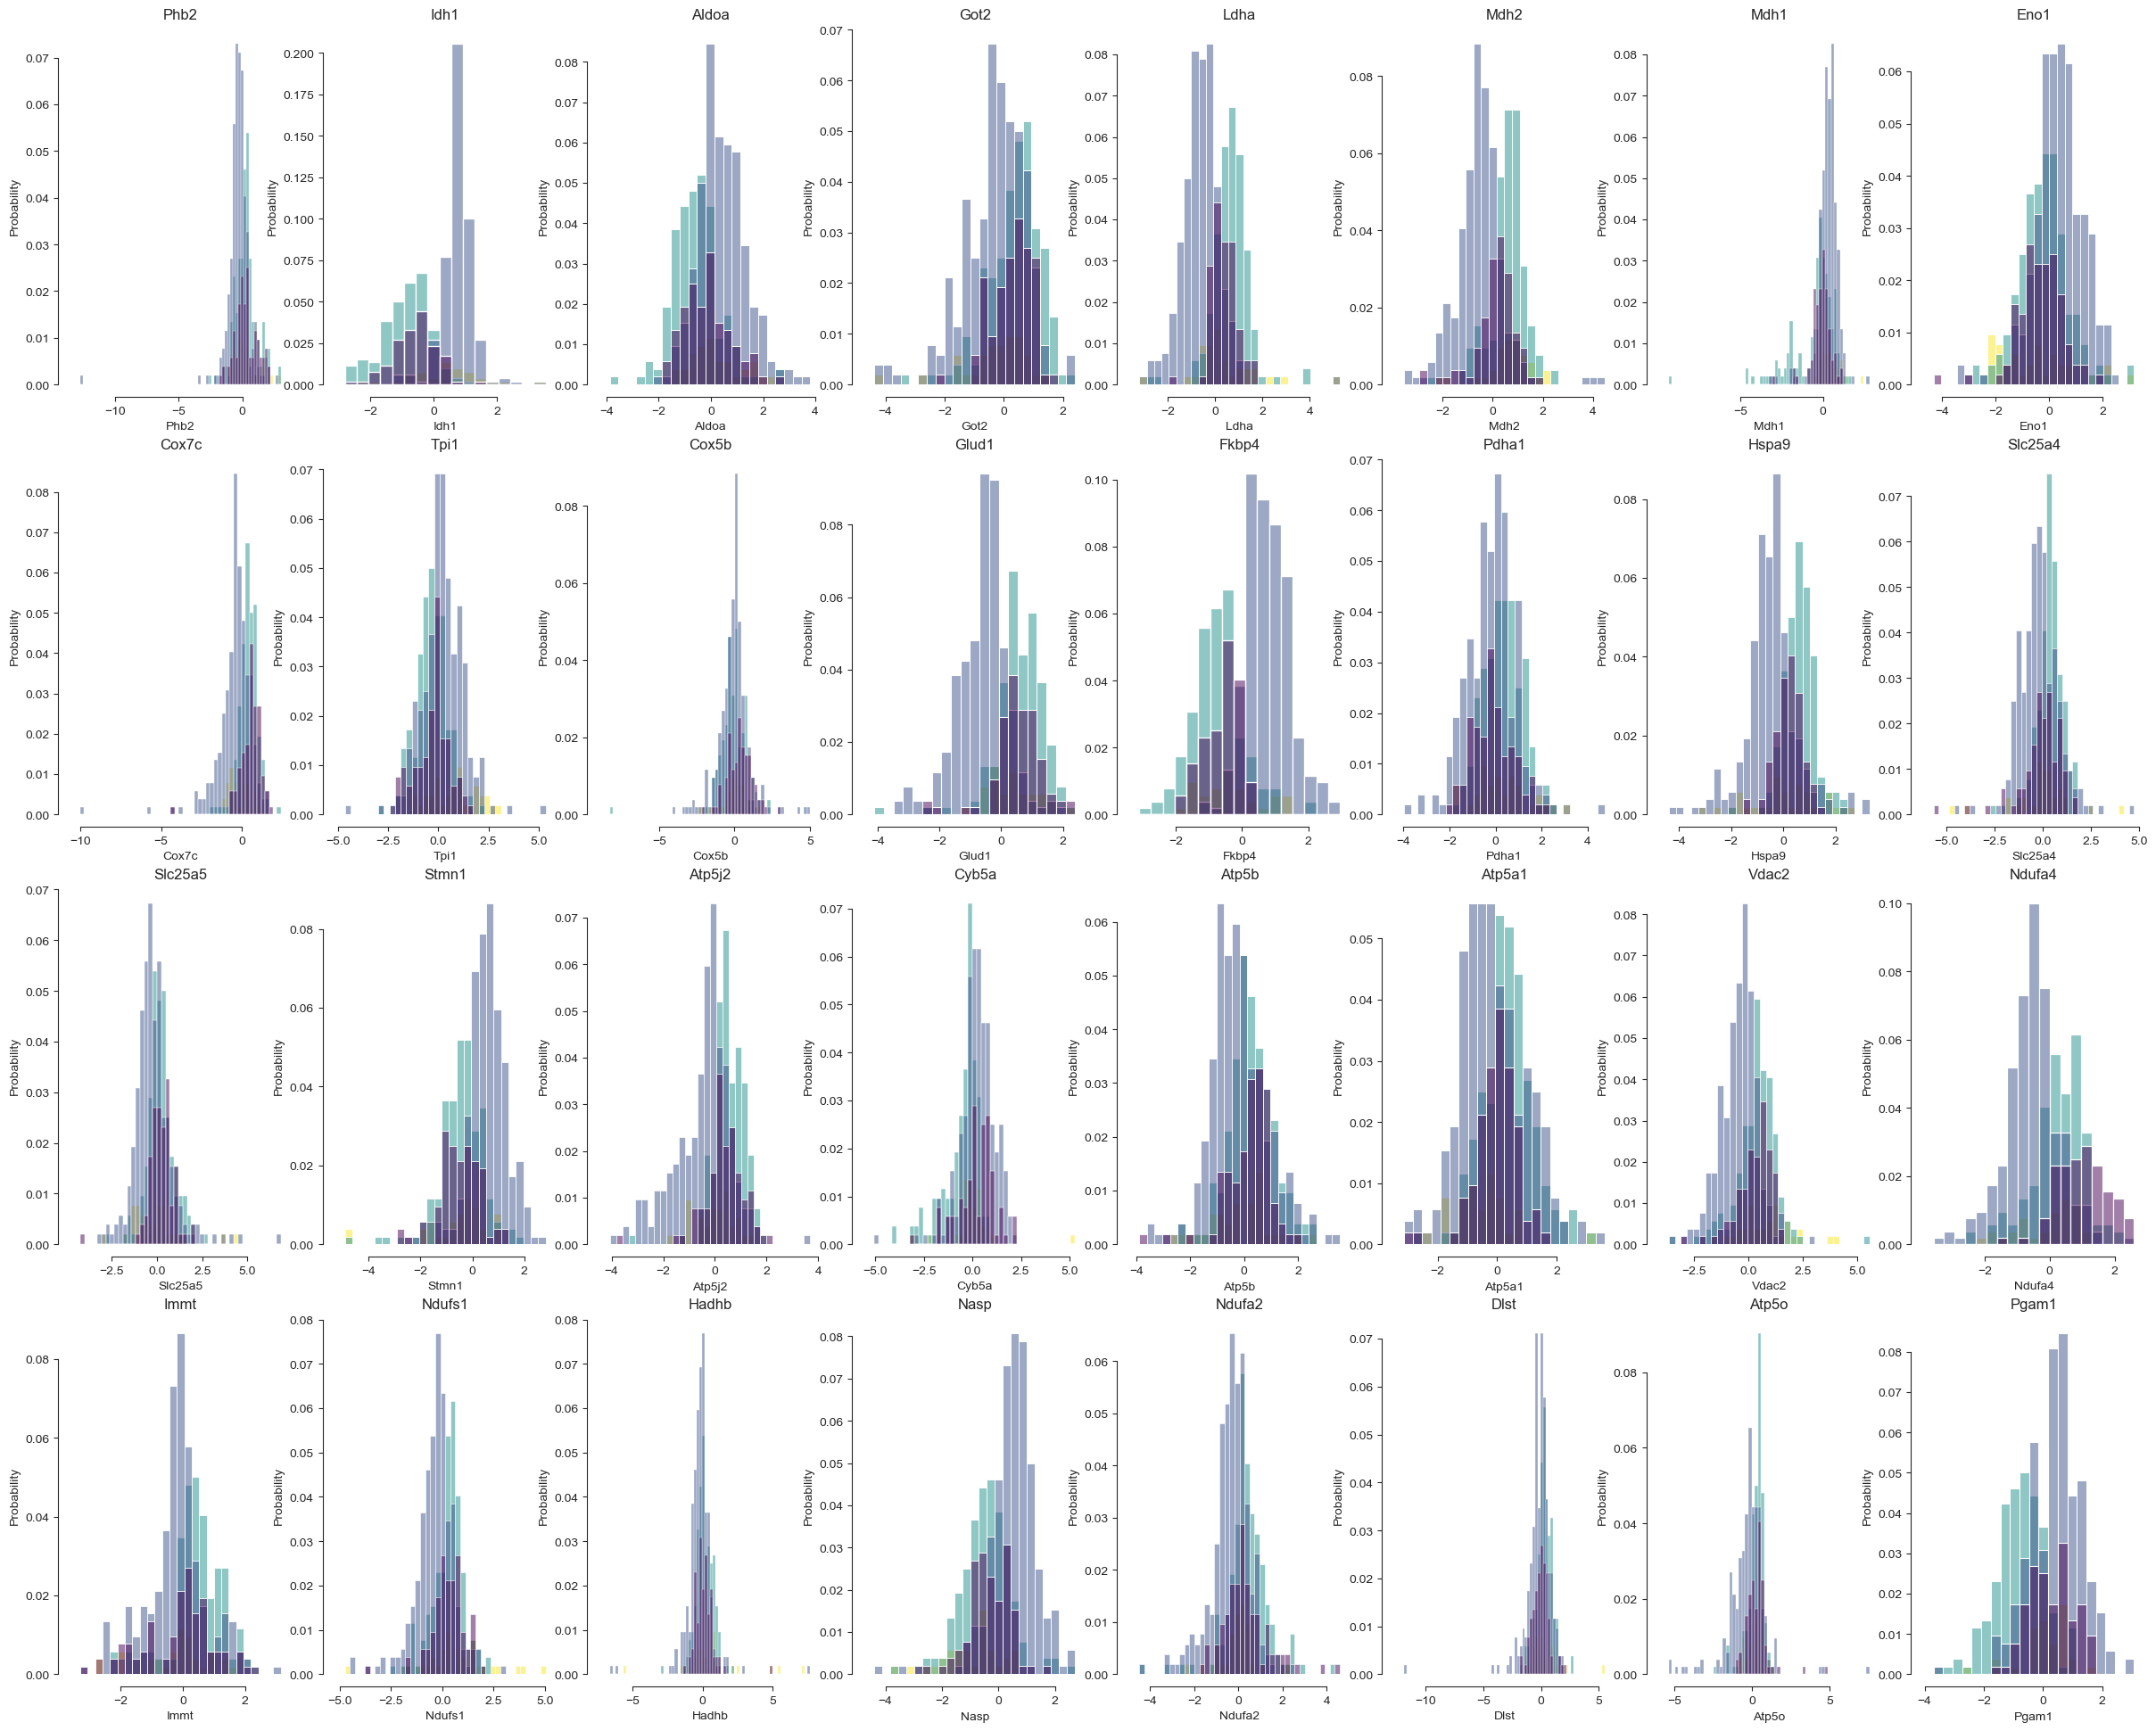

In [ ]:
fig, axes  = plt.subplots(4,8, figsize = (30,24))

i=0
for k, j in zip(glyco_oxphos_acc_gene['PG.Genes'].values ,np.tile(np.arange(0,8),4)):
    if i < 8:
        sns.histplot(data = pmap_metabolism, x = k, hue = 'Cluster', legend = False, palette='viridis', ax = axes[0,j], stat ='probability').set_title(k)
    elif (i > 7 and i < 16):
        sns.histplot(data = pmap_metabolism, x = k, hue = 'Cluster', legend = False, palette='viridis', ax = axes[1,j], stat ='probability').set_title(k)
    elif (i > 15 and i < 24):
        sns.histplot(data = pmap_metabolism, x = k, hue = 'Cluster', legend = False, palette='viridis', ax = axes[2,j], stat ='probability').set_title(k)
    elif (i > 23 and i < 33):
        sns.histplot(data = pmap_metabolism, x = k, hue = 'Cluster', legend = False, palette='viridis', ax = axes[3,j], stat ='probability').set_title(k)
    i+=1
sns.despine(offset=10, trim=True)

In [ ]:
clusters = pmap.Cluster.values
files_0_1 = pmap.File_Name[np.isin(clusters, [0,1])]
clusters_1_0 = clusters[np.isin(clusters, [0,1])]

gsea_data_0_1 = gsea_data.iloc[:,2:].loc[:,gsea_data.iloc[:,2:].columns.isin(files_0_1)]
gsea_data_0_1.insert(0, 'NAME', gsea_data.NAME.values)
gsea_data_0_1.insert(1, 'DESCRIPTION', gsea_data.DESCRIPTION)
gsea_data_0_1
gs_res_0_1 = gp.gsea(data=gsea_data_0_1,
                 #gene_sets='MSigDB_Hallmark_2020', # or enrichr library names
                 gene_sets='Kinase_Perturbations_from_GEO_down', # or enrichr library names
                 cls= clusters_1_0, # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=1000, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 method='signal_to_noise',
                 threads=4, seed= 42)

2023-07-05 08:28:30,007 [WARNING] Dropping duplicated gene names, only keep the first values
2023-07-05 08:28:30,014 [WARNING] Input data contains NA, filled NA with 0


In [ ]:
gs_res_0_1.res2d.head(20)

Name                                Term        ES       NES NOM p-val  \
0   gsea    TBK1 druginhibition 188 GSE53658 -0.604068 -1.873776       0.0   
1   gsea          AKT1 knockout 211 GSE39699  0.613961  1.873341  0.003752   
2   gsea  TRPM7 defectivemutant 306 GSE23102 -0.614772 -1.850317  0.005545   
3   gsea         CDK3 knockdown 110 GSE27869  0.552219  1.800999  0.001894   
4   gsea     ALK druginhibition 187 GSE50803    0.5483  1.800787  0.007491   
5   gsea        TRIM24 knockout 300 GSE19675 -0.577095 -1.739954  0.009881   
6   gsea         CDK8 knockdown 163 GSE38061 -0.545764 -1.688711  0.020619   
7   gsea         ERBB3 knockout 239 GSE32129 -0.524533 -1.684928  0.010482   
8   gsea        ROCK2 knockdown 157 GSE34769  0.462856  1.659898  0.008163   
9   gsea         IGF1R knockdown 52 GSE16684 -0.432876 -1.654392  0.010753   
10  gsea      RAF1 activemutant 219 GSE42964  -0.51351 -1.617198   0.02714   
11  gsea           RAGE knockout 268 GDS3755 -0.534269 -1.607032  0.022495   
12  gsea          PLK2 knockdown 87 GSE27869  0.450156      1.59  0.016917   
13  gsea        PRKACA knockout 266 GSE20984 -0.529517 -1.561659  0.023555   
14  gsea      ERBB2 druginhibition 8 GDS2139 -0.549486 -1.542077  0.053719   
15  gsea        MAP3K7 knockout 246 GSE34417 -0.463462 -1.536892  0.022044   
16  gsea         GSK3B knockdown 206 GDS4305 -0.464934 -1.522691  0.047521   
17  gsea            MET knockout 248 GDS3148 -0.478202 -1.514143  0.037267   
18  gsea          SYK knockdown 190 GSE54065 -0.370722 -1.497606  0.018595   
19  gsea  MAP2K1 druginhibition 172 GSE39984  0.441365  1.494792  0.040968   

   FDR q-val FWER p-val  Tag %  Gene %  \
0   0.193213      0.137   9/20  15.02%   
1   0.153076       0.15  15/29  22.18%   
2   0.127827      0.173   8/20  14.21%   
3   0.150567      0.272  15/28  21.07%   
4   0.100378      0.272  19/33  24.29%   
5   0.267828      0.407  15/19  35.69%   
6    0.31132      0.521  10/22  19.66%   
7    0.25801      0.534  12/22  31.96%   
8   0.298624      0.649  10/32  16.73%   
9   0.279805      0.624  19/50  23.79%   
10  0.324827      0.707  13/23  29.13%   
11  0.309258      0.723   5/17   8.87%   
12  0.419579      0.797  11/33  20.87%   
13  0.392185      0.808   9/16  32.26%   
14  0.405511      0.837   7/15  22.18%   
15  0.380964      0.844   9/24  37.30%   
16   0.38407      0.873  13/27  30.14%   
17  0.373376      0.882   4/19  17.94%   
18  0.386005      0.903  29/57  37.00%   
19  0.696928      0.927  20/35  33.17%   

                                           Lead_genes  
0   QDPR;PSIP1;RELA;VAPB;NME2;SNRNP200;CTNND1;CACY...  
1   PCBP2;LUC7L;BTF3;RPL7A;TUFM;RPS11;RPS16;RBM39;...  
2         PGD;FTL;PSAT1;TAGLN2;ILF2;EXOSC3;AHCY;KHNYN  
3   GLUD1;MTCH2;ABT1;MED17;RPS13;HSPA9;PSMD12;PHB2...  
4   MAT2A;EIF2S1;NEDD8;SF3B4;HSPA5;NOP56;PA2G4;DAD...  
5   IDH1;GLO1;EIF4EBP1;SFXN1;RPL27A;SKP1;LBR;MAPK1...  
6   ACLY;HMGCS1;NQO1;FLNC;IFITM1;IQGAP1;FXR1;CNOT1...  
7   FDPS;AK1;RRM2;LDHB;MCM3;UHRF1;TOP2A;KIF11;PKM;...  
8   NDUFA4;L1TD1;MAT2A;NEDD8;BOLA2;RPS16;HK2;CAND1...  
9   LSM4;STMN1;HMGB2;PRDX1;PSAT1;RRM2;PAICS;MCM3;U...  
10  STMN1;NOL12;PSAT1;POLQ;MCM3;TSTD2;VWA8;TOP2A;T...  
11                          CASP3;CBX3;VCP;LMAN1;TREH  
12  ATP2A2;NEDD8;SNRPA1;MED17;YWHAQ;DAD1;PCBP1;PSM...  
13  CBX3;PSIP1;BAX;MCM5;MYEF2;LMNB1;LIG1;DIAPH3;TRMT1  
14        LMAN1;SPTBN1;MYEF2;SSR4;CACNA1E;SEH1L;AP3B1  
15  HMGCS1;PSIP1;COL4A1;VAPB;FASN;EXOC1;CCT8;NUP10...  
16  TPD52;NOL12;SRSF1;LRRC40;CAP1;CACYBP;ANP32A;PT...  
17                            TPD52;SRSF1;LMAN1;MYEF2  
18  HSP90AA1;HMGB2;QDPR;VCP;HNRNPL;HNRNPK;POLQ;DNM...  
19  RPL23;VDAC2;RPS10;HSPA9;TUFM;RPF2;PHB2;AGPAT5;...

In [ ]:
clusters = pmap.Cluster.values
files_0_1 = pmap.File_Name[np.isin(clusters, [2,1])]
clusters_1_0 = clusters[np.isin(clusters, [2,1])]

gsea_data_2_1 = gsea_data.iloc[:,2:].loc[:,gsea_data.iloc[:,2:].columns.isin(files_0_1)]
gsea_data_2_1.insert(0, 'NAME', gsea_data.NAME.values)
gsea_data_2_1.insert(1, 'DESCRIPTION', gsea_data.DESCRIPTION)
gsea_data_2_1
gs_res_2_1 = gp.gsea(data=gsea_data_2_1,
                 gene_sets='Kinase_Perturbations_from_GEO_up', # or enrichr library names
                 cls= clusters_1_0, # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=1000, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 method='signal_to_noise',
                 threads=4, seed= 42)

gs_res_2_1.res2d.head(20)

2023-07-05 08:28:32,091 [WARNING] Dropping duplicated gene names, only keep the first values
2023-07-05 08:28:32,101 [WARNING] Input data contains NA, filled NA with 0


Name                              Term        ES       NES NOM p-val  \
0   gsea  JAK1 druginhibition 166 GSE38335 -0.628477 -1.813434  0.008403   
1   gsea  JAK2 druginhibition 168 GSE38335 -0.628477 -1.813434  0.008403   
2   gsea  IGF1R druginhibition 47 GSE14024 -0.494357 -1.734017  0.009921   
3   gsea        MET knockdown 254 GSE38343  -0.47567 -1.644804  0.011834   
4   gsea        CDK8 knockdown 88 GSE27869 -0.515395 -1.623524  0.023346   
5   gsea          MET knockout 262 GSE8747 -0.437276 -1.594682  0.014113   
6   gsea        CDK2 knockdown 90 GSE27869 -0.517235 -1.592074  0.026052   
7   gsea   FGFR3 druginhibition 36 GDS5023 -0.515591 -1.570086  0.041509   
8   gsea     PIK3CA knockdown 182 GSE46869 -0.420241 -1.565233  0.023762   
9   gsea           FGFR1 mutant 25 GDS4046  0.415174  1.546821  0.024341   
10  gsea      PRKACB knockdown 91 GSE27869  0.475237  1.542476  0.035197   
11  gsea    EGFR drugactivation 30 GDS4361 -0.382622 -1.541802  0.023529   
12  gsea       ERBB2 knockdown 234 GSE8373 -0.462133 -1.527545   0.03666   
13  gsea   SYK druginhibition 285 GSE43510 -0.498429 -1.514426      0.05   
14  gsea              BTK mutant 1 GDS1346 -0.461319 -1.510099  0.033203   
15  gsea       CDK8 knockdown 147 GSE32108 -0.465307 -1.486192  0.060606   
16  gsea      KIT activemutant 55 GSE17743  0.396838  1.478728  0.031746   
17  gsea       TIE1 knockdown 107 GSE27869  0.428012  1.456289   0.06383   
18  gsea       CDK8 knockdown 163 GSE38061  0.474756  1.446454  0.072978   
19  gsea       GSK3B knockdown 202 GDS4305  0.424516  1.436092  0.070423   

   FDR q-val FWER p-val  Tag %  Gene %  \
0   0.228291      0.275   4/18   4.54%   
1   0.228291      0.275   4/18   4.54%   
2   0.318113      0.459   9/35  11.79%   
3     0.5023      0.665  10/31  16.73%   
4   0.475717      0.717  10/21  20.16%   
5   0.495538       0.77  13/36  32.86%   
6   0.434436      0.778   4/19   7.66%   
7    0.44765      0.811   6/20  12.20%   
8   0.411771      0.822  17/41  32.86%   
9        1.0      0.873  30/57  38.41%   
10       1.0      0.875   8/23  10.18%   
11  0.435751      0.851  30/73  31.75%   
12  0.438966      0.874  13/25  36.09%   
13  0.435791      0.885   9/20  24.29%   
14  0.415032      0.889  10/24  37.90%   
15  0.449401      0.922   6/23  15.62%   
16       1.0      0.945  30/50  38.51%   
17       1.0       0.96  22/36  31.96%   
18       1.0      0.973   8/20  21.88%   
19  0.938563      0.974  14/32  32.66%   

                                           Lead_genes  
0                            PSIP1;HNRNPL;PSAT1;STMN1  
1                            PSIP1;HNRNPL;PSAT1;STMN1  
2   PGD;ACLY;PSAT1;STMN1;AHCYL2;SLC9A3R1;HMGCS1;MD...  
3   PGD;GSR;SLC9A3R1;FSCN1;CYB5B;LSM4;CYB5A;PARK7;...  
4   IDI1;EIF3B;SERBP1;ST13;QDPR;FLNC;IFITM2;PSMA1;...  
5   FDPS;FKBP4;PSIP1;TPD52;SERBP1;LBH;ACAT2;EXOC1;...  
6                             PAICS;AHCYL2;FXR1;RBM8A  
7                    IDH1;PGD;AHCYL2;CYB5A;TKT;CYB5R3  
8   IDI1;FKBP4;TUBB;GAPDH;TPD52;SLC9A3R1;RPL13A;CY...  
9   HSPA9;DDX21;BZW1;NOP56;PITPNB;COA7;SYNCRIP;TCO...  
10  RBMXL1;PABPC1;PPP2R2A;RTCB;NDUFA2;CCT3;PFDN1;RPL7  
11  FDPS;FKBP4;KPNA2;TUBB;PSMC3;PSIP1;YWHAE;EIF3B;...  
12  PAICS;MMP11;STMN1;EIF2A;LSM4;NFKB2;POLQ;PDHB;T...  
13  HMGB2;RPL13A;EIF2A;NDC80;ASNS;ALDH9A1;THOC2;KH...  
14  IDH1;EIF4EBP1;ACADM;PARK7;UBXN1;DDX27;NDUFA10;...  
15                 RPL35;GAPDH;NEDD4;RPS2;SLC30A6;BBX  
16  GLUD2;GLUD1;HSPA9;HSPA8;SNRPD1;IPO7;PSMD12;DNA...  
17  RPS16;SNRPA1;PCBP1;SRM;SYNCRIP;SRRT;ARPC2;COPS...  
18     ACTN4;LUC7L;NOP2;UTP14A;ACTBL2;ARF6;EHD1;CKAP4  
19  ACTN1;BTF3;RPL7;EZR;FAU;NCBP1;PSMD13;RAB14;PSM...

In [ ]:
clusters = pmap.Cluster.values
files_0_1 = pmap.File_Name[np.isin(clusters, [2,0])]
clusters_1_0 = clusters[np.isin(clusters, [2,0])]

gsea_data_2_0 = gsea_data.iloc[:,2:].loc[:,gsea_data.iloc[:,2:].columns.isin(files_0_1)]
gsea_data_2_0.insert(0, 'NAME', gsea_data.NAME.values)
gsea_data_2_0.insert(1, 'DESCRIPTION', gsea_data.DESCRIPTION)
gsea_data_2_0
gs_res_2_0 = gp.gsea(data=gsea_data_2_0,
                 gene_sets='MSigDB_Hallmark_2020', # or enrichr library names
                 cls= clusters_1_0, # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=1000, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 method='signal_to_noise',
                 threads=4, seed= 42)

gs_res_2_0.res2d.head(20).sort_values('FDR q-val')

2023-07-05 08:28:34,265 [WARNING] Dropping duplicated gene names, only keep the first values
2023-07-05 08:28:34,271 [WARNING] Input data contains NA, filled NA with 0


Name                       Term        ES       NES NOM p-val FDR q-val  \
0   gsea      Xenobiotic Metabolism   0.53265   1.59386  0.026316  0.276317   
1   gsea             Myc Targets V2 -0.473543   -1.5149  0.044211  0.339953   
2   gsea  Unfolded Protein Response -0.393295 -1.331673  0.118026  0.500256   
7   gsea             Myc Targets V1 -0.251783 -1.073306  0.341772  0.794145   
4   gsea           mTORC1 Signaling  -0.27889 -1.144719  0.234469  0.808271   
6   gsea  Oxidative Phosphorylation  0.322404  1.109286  0.312625  0.836746   
8   gsea        Allograft Rejection -0.329569 -0.962822  0.518887   0.90562   
18  gsea            Mitotic Spindle  0.188546  0.646234  0.938889  0.939107   
19  gsea          Protein Secretion -0.175886 -0.579781  0.979757  0.974204   
3   gsea                E2F Targets  0.309846  1.177908  0.206166       1.0   
10  gsea                    Hypoxia  0.285992  0.855338  0.631902       1.0   
11  gsea            Apical Junction  0.279596   0.80975  0.723282       1.0   
12  gsea      Fatty Acid Metabolism  0.234652  0.799648  0.762195       1.0   
13  gsea             UV Response Up  -0.22525 -0.779572  0.812144       1.0   
14  gsea               Adipogenesis -0.218083 -0.752777  0.863821       1.0   
15  gsea                 Glycolysis  0.221475  0.745904  0.848837       1.0   
16  gsea            G2-M Checkpoint  0.170333  0.663635  0.961111       1.0   
17  gsea                Pperoxisome  -0.21715 -0.658786   0.90303       1.0   
5   gsea                 DNA Repair  0.337493  1.113311  0.291165       1.0   
9   gsea                  Apoptosis  0.276722  0.874524  0.649541       1.0   

   FWER p-val   Tag %  Gene %  \
0       0.216    9/19  26.71%   
1       0.282    8/24  14.01%   
2       0.624   13/30  45.97%   
7       0.949  66/127  49.80%   
4       0.908   37/76  40.83%   
6       0.937   20/47  30.54%   
8       0.984    8/16  32.86%   
18        1.0   29/29  82.06%   
19        1.0   15/23  50.20%   
3       0.874   25/60  44.05%   
10      0.998   19/19  90.52%   
11        1.0   19/19  99.70%   
12        1.0   15/29  43.85%   
13      0.998   14/26  38.00%   
14      0.999   27/27  93.35%   
15        1.0   15/30  44.35%   
16        1.0   53/53  98.29%   
17        1.0   10/17  42.94%   
5       0.936    7/22  27.32%   
9       0.997    9/21  43.15%   

                                           Lead_genes  
0   GSR;CYB5A;MTHFD1;GART;ACO2;ALDH9A1;IDH1;ENPEP;PGD  
1         TCOF1;HSPE1;NOP2;NOC4L;WDR43;MCM5;TBRG4;SRM  
2   TARS1;FUS;LSM4;HSPA9;EIF4A3;IARS1;DKC1;SSR1;PD...  
7   ILF2;CCT3;SNRPG;HSPE1;COPS5;GLO1;DDX21;PSMC4;N...  
4   HSPE1;COPS5;PSMC4;HSPA9;ETF1;PITPNB;STIP1;PSMD...  
6   NDUFA4;CYB5A;CS;ATP5PF;COX4I1;PDHB;ATP1B1;COX5...  
8       RPS19;NME1;RPL39;EIF3D;RPS9;EIF3J;EIF3A;UBE2N  
18  YWHAE;FSCN1;PAFAH1B1;FLNA;SMC4;CAPZB;NDC80;ARH...  
19  DNM1L;ANP32E;SNX2;RAB5A;RAB14;AP2B1;AP2S1;MAPK...  
3   KPNA2;TUBB;HMGB2;RAN;PCNA;PSIP1;PAICS;EIF2S1;R...  
10  GAPDH;LOX;ALDOA;HDLBP;MIF;CSRP2;TPI1;HSPA5;TPD...  
11  ACTC1;FSCN1;ACTA1;YWHAH;MYL12B;FLNC;PPP2R2C;AC...  
12  PDHB;ALDOA;ADSL;MDH1;ACO2;ALDH9A1;IDH1;YWHAH;H...  
13  TARS1;DDX21;STIP1;SLC25A4;HMOX1;DNAJA1;TUBA4A;...  
14  MTCH2;MDH2;IMMT;PFKL;IDH3A;LIFR;QDPR;ME1;AIFM1...  
15  PGAM1;CYB5A;ALDOA;MDH1;ALDH9A1;IDH1;FKBP4;HDLB...  
16  KPNA2;HNRNPU;KPNB1;SRSF10;PAFAH1B1;MCM2;RBM14;...  
17  PRDX1;SLC25A4;MSH2;CDK7;TOP2A;PABPC1;SMARCC1;I...  
5             ALYREF;PCNA;SRSF6;BOLA2;SSRP1;GPX4;DDB1  
9       HMGB2;GSR;CASP3;SOD2;RELA;GPX4;GSN;SOD1;HSPB1

#### Single cell geneset enrichment

2023-07-05 08:28:35,071 [WARNING] Dropping duplicated gene names, values averaged by gene names!


<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

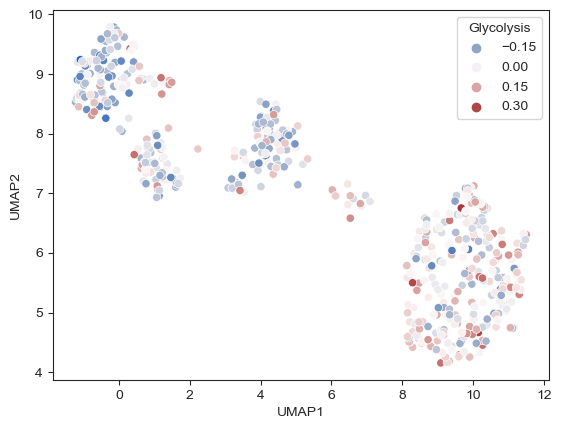

In [ ]:
gsea_data2 = gsea_data.drop('DESCRIPTION', axis = 1)
gsea_data2.columns = np.insert(pmap.CellID.values, 0,'NAME')
gsea_data2


ssgs_res = gp.ssgsea(data=gsea_data2,
                 gene_sets='MSigDB_Hallmark_2020', # or enrichr library names
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=1000, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 method='signal_to_noise',
                 threads=4, seed= 42)

ssgs_res.res2d

df_NES = pd.pivot(ssgs_res.res2d, index='Name', columns = 'Term', values = 'NES')
df_ES = pd.pivot(ssgs_res.res2d, index='Name', columns = 'Term', values = 'ES')

df_NES

pmap_gsea = pmap.merge(df_NES, left_on = 'CellID', right_on = 'Name')


sns.scatterplot(data = pmap_gsea, x = 'UMAP1', y = 'UMAP2', hue = 'Glycolysis', legend = True, palette = 'vlag')

In [ ]:
pmap_gsea

UMAP1     UMAP2                                          File_Name  \
0     4.013513  8.294025  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
1     0.699618  8.905088  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
2     0.280513  8.681312  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
3    -0.280279  8.544475  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
4     2.226473  7.743897  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
..         ...       ...                                                ...   
515  10.808461  6.371929  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
516  11.245189  5.672690  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
517  10.157985  6.195972  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
518   9.977836  6.410796  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   
519  10.797932  5.288779  20230421_EV_PAF_FAIMS_U3000_uPAC_wishDIA_plate...   

       CellID  Detected_Proteins  Intensity CellType  QC_Pass Position  \
0      cell_1               1140   7.493173      m15     True      A10   
1      cell_2                726   8.367414      m15     True      E12   
2      cell_3                950   8.050534      m15     True      E13   
3      cell_4                994   8.056626      m15     True      E14   
4      cell_5               1165   7.559803      m15     True      E15   
..        ...                ...        ...      ...      ...      ...   
515  cell_604                709   8.433825      m2i     True       E7   
516  cell_605                728   8.477236      m2i     True       E8   
517  cell_606                904   8.038930      m2i     True       E9   
518  cell_607                822   8.302719      m2i     True      E10   
519  cell_608                957   8.144512      m2i     True      E11   

         TIME  ...  Mitotic Spindle  Myc Targets V1  Myc Targets V2  \
0    175.4116  ...        -0.052592        0.076527        0.048445   
1    203.3616  ...        -0.019049       -0.129592       -0.041182   
2    212.6815  ...        -0.002661        0.040991        0.021444   
3    236.4491  ...         0.021915        0.056219        0.138212   
4    246.1141  ...         0.009234       -0.017964        0.264885   
..        ...  ...              ...             ...             ...   
515  105.8815  ...         0.013395         0.00261        0.021834   
516  129.7211  ...         0.007663       -0.039152       -0.102731   
517  138.7414  ...         0.049116        0.016755        0.163563   
518  162.4921  ...         0.247711       -0.026945       -0.006707   
519  171.7456  ...         0.009939        0.103461       -0.058212   

     Oxidative Phosphorylation  Pperoxisome  Protein Secretion  \
0                     0.242894    -0.015608          -0.169272   
1                     0.063559     0.084976          -0.121436   
2                    -0.042858    -0.006405          -0.107382   
3                     0.001932     0.013128          -0.103042   
4                     0.184893      0.02597           0.119242   
..                         ...          ...                ...   
515                   -0.07806     0.168569           0.137568   
516                   0.111136     0.140551          -0.015239   
517                  -0.065672    -0.116164           0.101659   
518                  -0.269596      0.05963           -0.05755   
519                  -0.182168     0.028006           0.093214   

     UV Response Up Unfolded Protein Response  Xenobiotic Metabolism  \
0          0.008403                 -0.080038              -0.149098   
1         -0.060021                 -0.023183              -0.195041   
2         -0.009059                 -0.072295              -0.014728   
3          0.013688                  0.141368              -0.129575   
4         -0.020559                 -0.058683              -0.162913   
..              ...                       ...                    ...   
515        0.056786  

In [ ]:
# multi in one
#terms = gs_res.res2d.Term[:5]
#hits = [gs_res.results[t]['hits'] for t in terms]
#runes = [gs_res.results[t]['RES'] for t in terms]

In [ ]:
exportData = False

if exportData:
    sc_quant.quant.to_csv('output/mesc_quant_raw_direct.txt', sep= "\t")
    sc_quant.summary.to_csv('output/mesc_summary_direct.txt', sep = "\t")
    quant_filtered.to_csv('output/mesc_filtered_quant_direct_keratin.txt', sep ="\t")
    pca_2.to_csv('output/mesc_pca_direct_keratin.txt', sep = "\t")
    sc_emb.to_csv('output/mesc_umap_direct_keratin.txt', sep = "\t")
    pmap.to_csv('output/mesc_pmap_direct_keratin.txt', sep = "\t")
    acc_genes.to_csv('output/mesc_acc_genes.txt', sep = '\t')
    pmap_gsea.to_csv('output/mesc_pmap_gsea_direct_keratin.txt' , sep = "\t")
    gs_res.res2d.to_csv('output/mesc_gs_plate_keratin.txt', sep = "\t")
    pmap_gsea.to_csv('output/mesc_pmap_gsea_keratin.txt', sep = "\t")
    pmap_metabolism.to_csv('output/mesc_pmap_metabolism_keratin.txt', sep = "\t")
    glyco_oxphos.to_csv('output/glyco_oxphos.txt', sep = '\t')